In [248]:
import pandas as pd
import numpy as np 
import _pickle as cPickle
from joypy import joyplot
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def min_max_scaler(pd_col, col):
    x_max = pd_col[col].max()
    x_min = pd_col[col].min()
    pd_col[col+"_scaled"] = pd_col[col].apply(lambda x: (x-x_min) / (x_max - x_min))
    return pd_col

In [107]:
wiki_metadata = pd.read_csv("article_metadata.csv")
embedding = pd.read_parquet("wiki_comment_embedding.parquet")
embedding.index.name = "page_title"

In [508]:
# process gs score
gs_score = pd.read_csv("/scratch/venia/web2wiki/playground/gs_score.csv")
gs_score.rename({"domain":"page_title"},axis=1,inplace=True)

In [520]:
gs_score = min_max_scaler(gs_score, "GS_score")

In [108]:
for i in range(150):
    embedding[i] = embedding[str(i)]

/tmp/ipykernel_2245120/100951990.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  embedding[i] = embedding[str(i)]
/tmp/ipykernel_2245120/100951990.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  embedding[i] = embedding[str(i)]
/tmp/ipykernel_2245120/100951990.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

/tmp/ipykernel_2245120/100951990.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  embedding[i] = embedding[str(i)]
/tmp/ipykernel_2245120/100951990.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  embedding[i] = embedding[str(i)]
/tmp/ipykernel_2245120/100951990.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

In [109]:
wiki_metadata = wiki_metadata.dropna(subset = "page_id")
wiki_metadata["page_id"] = wiki_metadata["page_id"].astype(int)

In [15]:
file = "/dlabdata1/wiki_embedding_project/article_text_embeddings/article-description-embeddings_enwiki-20210401-fasttext.pickle"

In [20]:
with open(file, "rb") as f:
    wiki2vec = cPickle.load(f)

In [110]:
page_ids = wiki_metadata[wiki_metadata["count"]> 99]["page_id"].values

In [111]:
def process_wiki2vec():
    new_dict = {}
    for p in page_ids:
        try:
            new_dict[p] = wiki2vec[p]

        except:
            pass
    
    wiki2vec_df = pd.DataFrame(new_dict).T
    wiki2vec_df = wiki2vec_df.reset_index().rename({"index":"page_id"},axis=1).merge(wiki_metadata[["page_id", "page_title"]])
    wiki2vec_df.index = wiki2vec_df["page_title"]
    
    return wiki2vec_df[range(150)]

In [112]:
wiki2vec_df = process_wiki2vec()

In [120]:
index_vals = set(wiki2vec_df.index).intersection(set(embedding.index))

In [121]:
def get_axes(dff,index_vals):
    df = dff.copy()
    df = df.T
    df= df[index_vals].T
    return df

In [125]:
wiki2vec_df = get_axes(wiki2vec_df,index_vals)
embedding = get_axes(embedding,index_vals)

/tmp/ipykernel_2245120/3064374100.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df= df[index_vals].T
/tmp/ipykernel_2245120/3064374100.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df= df[index_vals].T


In [126]:
from sklearn.metrics import pairwise
def cosine_similarity(embedding):
    index = embedding.index
    similarity_matrix = pd.DataFrame(pairwise.cosine_similarity(embedding.values), index=index, columns = index)
    return similarity_matrix

In [127]:
sim_sem = cosine_similarity(wiki2vec_df)
sim_beh = cosine_similarity(embedding)


In [174]:
# calculate h_index
def calculate_h_index(wiki_metadataa):
    wiki_metadata = wiki_metadataa.copy()
    h_index = wiki_metadata.groupby(['class'])
    lis = []
    for i, group in h_index:
        temp = group.groupby('page_title')['count'].sum().sort_values(ascending=False).reset_index().reset_index().sort_values(by=['count','index'], ascending=[True,False]).reset_index(drop=True)
        ret = temp[temp['index'] <= temp['count']]['index'].max() + 1
        lis.append({"class": i, 'h-index':ret})

    k =  pd.DataFrame(lis).sort_values(by='h-index',ascending=False)
#     wiki_metadata = wiki_metadata.merge(k, how = "left")
    return k

In [176]:
h_index = calculate_h_index(wiki_metadata)

In [183]:
h_index.head(3)

,group,h-index
1478,Human,339
3196,Taxon,228
26,Act of Congress,131


In [131]:
from scipy.stats import pearsonr

# define the pearson correlation
def extract_pearson_cor(sim_sem, sim_beh)
    lis = []
    for i, k in enumerate(sim_sem.index.values):
        if i % 100 == 0:
            print(i)
        try:
            val,prob = pearsonr(sim_sem[k], sim_beh[k])
            lis.append({'page_title':k, 'pearsonr': val,'prob':prob})
        except:
            pass

    pearson_cor = pd.DataFrame(lis).sort_values(by = 'pearsonr')
    return pearson_cor

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [ ]:
pearson_cor = extract_pearson_cor(sim_sem, sim_beh)

In [141]:
wiki_metadata = wiki_metadata.merge(pearson_cor[["page_title","pearsonr"]])

In [156]:
wiki_metadata2 = wiki_metadata[wiki_metadata["count"]> 100].sort_values(by = "pearsonr")

In [394]:
from urllib.request import urlopen


# create a file-like object from the url
little_prince = urlopen("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxISEBUQEhISFRUVFhcWFRcVFRUVFxYWFxgXFhYXFxUYHSggGBolHRUVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGhAQGy0lICYtLS0tLS0tLS0tLy0vKy0tLy0tLS0tLS0tLS0tLS0tLSstLS0tLS0tLS0tLS0tLS0tLf/AABEIARoAswMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAAAAgMEBQYBBwj/xABEEAACAQIEBAQDBAgCCQUBAAABAhEAAwQSITEFE0FRBiJhgTJxkRQjQqEHUmKCorGywXKSM0NTg8LR4fDxFiR0k9IV/8QAGwEAAgMBAQEAAAAAAAAAAAAAAAECAwQFBgf/xAA2EQABAwMCAwYEBQMFAAAAAAABAAIRAxIhBDETQVEFImFxgfAykaGxUsHR4fEGFEIjM4Kywv/aAAwDAQACEQMRAD8AnZ6M9MZqM1dWFnTueuZ6bz1wvRCE7mrhemc9SOH3WF1GUZiGGkTI2IPsTUKhsY5wjAJyYHz5eaBukTRNa7inAlFu5yAoa4ROY5QFGpVdNJIFYnPWHsztOlr2udTxEYMTkc48ZA6xPOBZUplhyn81cLUyblJNyunCrTuegvUc3abN2nCUqSXrhuVFN2kG7UrUSpRu0g3ahXcSFEkxqB8ydAAOpPYVJTh2LYZlweKKnrywv8LMG/Kq6lWlSjiODZ6kCfKSmATsEG7XBe1B3127+lQr94o2S4r22mAt1Gtk/IOBm9ppDXauba9tzTIPMfkVEkgrR3fEbvZv2rksbrIykbJlYEqB0WFEVSG9UQ3aQbtV6fR0qAIpNgEzA2mA3A5YaEOeXbqYb1Nm7UQ3aQb1abFFS+bRULnUU7ULUm5STdqGbtIN6s4apSpxu0k3ah82kc2pWolTTdo5xqAb1BvUWolWWL4ibuQtrkQIs66AnX/vsKmcJ4ZexKnl5AqHVmIWCekxm6fKs9za6l1dc0xBiO8HLPpMVQ7TFlGyjDY27t3UnEjfPPBPgAndJk5WtPhXErDRZua/CLmjen4fyNVHE8I9m5kuoUJGZVzK5gzlGYaHUR7VI45dy8PwKd+a/wDECPyeq/w9N3GWFJJm4pMmdFOYj6KaxaWpX4T69Z7S1vEGGkGGOcJ+MtzbPwzmJIU3BshrR059QD08UzeZlJVgVIiQwgjtvqNDTJvVK8U43Pjb5MH7xkH7n3YP8M1VjEjKylZJKlWn4YmfmCD+Qrp0C99Jj3NgkNJHQkCfl/AnCqdEkJ93IgnqJHykj+YNNXMQACSdBqaZS6sNmLTl8kdWzLo07DLmPsKleGUF3H4W2dQbwJB2+7Vrv80FFeoKNGpVI+EE+cC79vRDRJA6r0PwR4YFpVxWIX/3DCVVteQp2UD/AGhHxH1gaDXYUUV8g1Wpq6qqatUy4/TwHQDkF2GtDRATWMwqXUNu6iujaFXAZT8wa8o8beGjg2Fy0SbDmADJNptwhb8SkAwTqIgzpXrlVviTh4xGEvWT+JDl9GHmQ+zAGtnZHab9BqA8HuEi4ciP1EyD6bEg11aYe2Oa8KN6kG7UTnSAe4pJuV9hsXHuUs3abN2opuUk3KdqVyl82ioXMrtO1K5ac3qQb1QubXDdqi1Wqcb1JN2oJu0k3adqUqab1cN6oXOpJu0WIlTjeozmC0GAQCegJmBPsfpVebtc5tSDMpXLbeJLqrZ4fnEr9lzR3JBI9py0n9G6h8cumqJccmemUINP3z9aieOGy4fh3/wrR/hFN/o84lbs4i8111QNh7qKzkKueUYDMdBoprzbmuf2LVcwEktqD5vfOB4OM+HktAIFYT4fYKXxXhiXLeJxmGxSXgHLXkFt7ZVbjlgRmPnWdZgA5SekVXcB4ScSzFXRLdq3mv3LwGS3IYaAHzbEgmNjtAl/wi1tcBxJ2cA8lbag6Elg8aerQBVh+j7iLnD4qzaNr7TcYPbF2MlyPjXsSBm0/aHSau1Favp6OoZTdPDcxoc4NEBwpyXQ0NhgcTNsNxIIBlNAcWzzBPynaev6ql45wPk2lxFq/bxFh2yZ0BWLgBOVkJJGgOs/TSYnhjHC1jsLdYwFvKCewcG0T/HV743xGKWxaXFPYR+YXTC2rS/DBAu3odlB+IBRIOY6mNMGWkQetbNCH67QubVcCHXtubmQZG9rWuI/EwBp5CZKreeHUEDp75r6forFfo58YJi7K4e64GJtiCG0N1RtcXuY+IDY+hFbWvkup01XS1XUaohw3/UeB3BXXY4OFwRTWLcLbdjsFYn2BNOxXmf6TPG1sW3wOGfM7eW86nRF/FbB6sdjGwnrVug0FXXVxQpDJ3PIDmT4D67DKVSoKbbivKxd2PcTXDcpqia+4EBeflKz1wtSZomhJdmu0minCUKzN2km7UYvSTcquxW3KVzKTzKl3eE3Dhftyqq2eYLUZyWz5QxMR8JM9etVxU5Q+kEwNROn7MzHrEVWyox82kYMHwdzb5joh0jdOm5QblMWpZgoIE9SQAPmTtShdXIRlOcsCGnQKAZGXqSSNemX1qwj8vr5kfr0BSuSzcrqsDMmNDGkyeg9J71HUiRMxOsaGOsT1rt9wWYquVSSVWS2UE6LJ3gaT6URmPr7z9Ixk7SrlZYzjmIum21y6zG0oS2dAVUarqoEn1Mn1qEb5yhegJI+bBQf6Vp/C8Nu3bVzEBJt2OWLrDKCoc5RAPxHTp8zvVeahSZSb3aYAt5CMGJjGxh0xv3p/wAk3FxyffJPXQQYYEGARI6MAwPuCD70PfkKBIjXckZurDsTA+lIvrDFcwaDEgyDGmh6ikrcgEQNY1iToZ0PTp9KsGQDz9ef8/VRT1xiw5jFyxaCSJBgD8ZMlttI2jWo9aXwNwEY666Xbr27Fm211ypEjYCMwIHUkxstT+PeD8OMK+MwGK59u0QLito6yQJkAbSDBUaSZrC/tOhT1H9u8me6JtdaC74GlwEAu5TvtKtFBzm3D9/ksclwghgSGUypBIII2II1B+VaQePsfy+Wb2aPhcqOavycRPvNZsrlYq6mQCImIboToZjtTU1dX0em1UGtTa6NiQD8j7Hgkx72fCYV9d8Y8QZcrYu8QdD5gp19VANUc0OsQZGonQzGpGvY6THYjvQLZKlo0BAJ7FpIH8LfSp0tPQoA8JjWz0AE8uQHPaZScXO3MpM0TXUYQZEyNNYgyNfXSRHrSKvCjCVNcmgD86VdTKxWQYJErqDBiQeoo8E0maK5RQknKcs2mdgiiWYgAdydBvtTdcDRrSMwY3SAW2xVyPDtoD8eNYH2t3D/AMIrEzWzsDP4duH/AGWOBHvaQfzuGspiLaJeZCxdFZhmQjUCQCCR8v8AvWuZ2Y4A1xz4tQ/9T/6Hmr6zZtPgFP4lwfEW8PZxV0Dl3RFo5wxhRoCAfLoNvrBqHa4deYsq2nYonMfKpbKkA5jGwgjWrnF8Dy8Nw2LVnuG69621vUrbIzwyBdQYtlj00E6b6nwLwTlYHFX3xWGtjEWFUPzQTZDllPN2CMZAAncdCKp1XarNNpzUuaSHlgFpAniWxAuPdAJPJ0d3eFJtC50Ryn35rzcqWDOFAUETGy5ttzPSnMVhrlqFu2mQsFdc6spKGYIndT3/AGfnVphPDhvYl8Kl+wQJZbzubdl0HlYoSpLnMY008jb7jT/pawVs3+d9qss1tbdkYcH71VHmJMTGrE6gaEb1a/tOk3V0tM0zcCdnSPhtnBi4kzdbEEOjExFE2Fx5eXqofA1jgGNYbvftWx6wbJj+M1kcZdYAWWy/dM4DDcydRPVQQSNPxN302DFU8OSAQL2N0BIJhV2LQJMWt49qTwDwzafBvjcR9qFi7cK27OGQXbjBC0FmKnQFWEkD4d9QKx0NVTocetVnNdwAiSXBrWACOcBx2jeSN1a6mXWtH4f1/ZY03E5eXIc+ckvJjJlACBdt5M/Ko5NaDxj4dGDu28ju9u9bF21nUpcCnZbikCGHt8hWertaatTr0hVpGWuyN/I77QQRHIgrO9paYK9B8BYdxg+KqoLsbCW1FuXJLreELG51jTtS76Pw3hN6ziMq38XlW3alSUsrpmeNAdWHXUr6xD8E8TuYfhvErtpitxfs2VhBIzO1uYOmkmsne4jeuXTfa7ca6ZlyxLbHY9AATttXDboqtfWV7i2wVKZP4nOZSpOAnZrLiCdzyHjpNQNY3rB+5TF9nLHOWLDynPMjL5cpnURER0irLgXB8TjHuW8OFJCm465lQFQdAAd9SNNhptWuTwlhbnDcNfu37eHe6zvdvXSzNcJLAIqFgDoJnfTrJqHwrwvZu477FZxudBZe4t21lGe4YBtyJ8sakSdAe5rQ/tegaVSw2ll0k03FosdBIjBEiQLrgIOIhRFBwInM+PVYm2wgysyNNSIPRhH8j39wirnwxwsYzF28Kfu+ZpmEmMiFmOUnUkIeoALbRpVzxfwSbFi7iLOLs4g2LgW8iCTb82UEySDB3BAGh3it9bX6ejXFCo6HmIEE/ES0ZALRLgW5jPWRNQpOc24bLIWkzGJA31JAGgnc/KlXbrOZgTH4EVBAkk5UAG061c+GuAHGXbha4tuxZBuX7xGiprED9ZoMD0PaDN4rwTA8o4jB4vmLbK82ze+6vEEgTb8ozb9Bp36VGprqDK3CMl2BIaSGl2wLgIaXYgEicTuExScWys5exJZEQhfIGAIHmILF4YzrBZo/xfKhnTlhQpz52LPOhUhQqhfQhzP7XpW04L4WsnBfa8V9rFq/c+7s4ZBceELhXdnUiBLRoNNesCg8YeH/ALDfFoMXV7a3bZK5WyMWADr0YZTP9thXQ7Q01WudOwkOBdyMEj4xOxLXONw+GRIJjDdSeG3H30VFRRRXSVKeKU2wozHua4TRCF6F4EwQxfC8bg+Zbtk3LVwM5yhYKmT6fdxUDGeE8Phka7//AFMI122M9u1bCXM7rqqkZjuQBqpGuulY66+Y5iQDpsABoABAAgaAU5cury1UIAwJLPmJLT8Iy7AD01M6naOT/YVxWe9lYhj3XOYGMP8AgA6XPmQbeTcE9JKv4rS0AjIELbYW0LnAsTh2uWxdwuJN3KzKDlyZTl6GSbgEbnSk+DeHXMXw3H4e1Bus+GgSqAgMTvtsG+cVh0C6knUfCImTIkEzppJnXaPWnFxDAtkJQMIIRmAK/qnWSPQk03dnvsqNpvguqNqAlshpDmOIi4EtJZO4iclAqiQSOUfcfmrnEcJXC4xLYvW74tNba+9ucltuYAyZj8UeXzaamIEGtJ+kHwswxOKxt+7btW2M2VnNcvvkWFVQdADuTsATEa157mGWMo331kDtExHtNLv32cy7MxAiWYsQBsJPT0qx2jruq06gq/C0tcbWy4EscYza2S2JtMNMb95IVGgER7+63PiO0bXAMDaaAz33u5Z1g84gx6C4s9iYq08O8Va9gLGGtY1MHfss7MHcWxdS4zMrBiCJGbUQTIOgBBrzHNpBLafCNxqZPXTvoNabis7+x21KPDc7PEfUm0ES4uxa6QRDiOs5kEKXHh0gcgN+nitJ41xSNiPJiruJYW1S9eZhkdgZy2go0tggdSCdfU5uluRpAI01kgye40EDbTXbeuLEiZI6wYMdYMGPpXS09EUKTaYzA8JPoAAPAAQBAAgKl7rnEra+CrKvgeKKAYGFRiDB89vmPpHSVkVjHukqqmIWYhVB1MmWAlveYpyxi3tluW7pnUo2ViMyNurRGYHtUeqtPpnUq1WoTIeWkDmCGBhnzDR6YUnPkAdP1Wx8YYlW4bwy2GGa2l5biT5kYNbXzLuplW3qP4CxC2OI4a8Wy2i728zQvmNvKQQCYGa6uv8A1jN2kUzmbLAJGhMnoum3z9KaqsaBv9q/Slxh3EBxyqFzjHLBdjfbIzh8TvB8dPoAF6H4es2sLx5xdu2FRHvOr5hlBZXyKX2VsrmRtI7xUfwPjOdxK/ZaTax4xNttNJIe4D8wJ/z1iGUZoUyJhSQBI6EiSF+tKW6yHyuQVJgqxEHYlSO4G4rPV7MFVlSXy99JrJIiC24h8TM3kOjMEDPSYrWkYwDK1vhS5a5eN4bduLYa9kCXGbycyw5zKzdFY7ekjUxMHj/hpcHZHNxGHN4sMtuyWuMUP4naQqAQY8pJnftQWQxBRZIjOwHZAxzH5At9TSVUZW1giIEbyddehG/rr76RpXt1DqjKpAJDnNABk2hu+4a4NAI70xIc0yoXgtgjwC9Q4PxRr+Bw9izjreDvWFZXS462xcRgDbuBiDmgQSsfiI00NYzxljEfEkW8Tev+VVu3nIy3HXfIFAAtjSBrsTruc9FLcjSARoJkgyepGggemvzNU6Xspmn1DqoO8mLWiLjcZdFzhdlocTb4w2G+sXNj8/y280iiiiuqqUUV2K5QhFFFFCEUsXDlKzoSCR6gEA/Rj9aRRQhOHykEMCdDpOh7GRuKCSxZiwnVjM+Yk6gQN9SdY2NN0UoTlFLLmAs6CSB0BMSfmYH0FIoppIooooQiiiihCWxWBAM65iSIPaBGn1M+lIoooQinLTwZgN6NMbR0puigiRCEpWI2JEiDHUdR8qTRRQhLa4SACTAmB0E6mkUUUIRRRRQhKVyKTSooihKUmgmlRUjh1xUvW3f4VuIzb/CGBbbXYHbWkTAJQFreAfo9u37ZuO+UgA8lVJuwTrIg5SANZBgnXXQx/E3gS7hEzrcF2FDOgRluII8xKncA6mNgZ1AJr1fgl2y+FbDHlDmuQ5JQqbRkjdhmDQdAdnkbVG49jow1pr0FrKst25mBUqBCsXSQWYCcoM5jAHWvOjtCvddPpyW80WRC8CrtKUaURXoysErkVyKXFcihKVyKIpVdC7fOmBJhFy41siCQRIkT1EkSPSQR7Uv7M2bJkbN+rlObv8O/UfWvX7XgKxiFwd97rKi4ayHtBV88DN8XQHMZ019K12J4FYe3fCTbbECLly3AfRVUQ3YBRptv3rxtb+saDA21hMzO4DTcAORnuyTbzgA5MbxoXHc+/wCcL5ty0RXo/j7wJbwmHGIsuAiZVYNma5cd2jMWHlA20AArzzLXo+z+0KOvo8ajMSRkQQR9NoOCd4OZAyVabqZgpEURS8tGStyplIiiKXloyUIlIiiKXkoyUJykRRTmSinJSlIiuxTot13lVGQpQmKKki1SuVRcEWlaXhnitLGB5KpcOIUoEd3JQqWZnXKsFEUKigBpbP0AgNeIPEdvEYS1aVLi3YVrzB/IzhnBUpGojK4MmC0HaRn+XS+VWQaWiH3gZmff35K41HxCiZK7kqWLVd5VarlXYogt10W6lizXRaqN6LFD5Va79GlhWxjB1RkNm4HV8pBU5TGU/Ft0rPizWi8B4LPxCyTMJmuEDchFJy+5gfWsXaLeLpKjCYlp98vTpvyV1AW1AV6s7PAZVIQMEVQhkgQDp+FRqNulOHFAGDIggGekxE9pmrXD4rNrBHlDGeklt/8ALUXE2bdy2XGzETuJIMa9Z0H0rxDtFTIA2jC7F5UXFILtprbqtxHUgq2oYHp/1rwDFWIdhkKQxGUkkrBiCTqYr1Lxnxw2rRwo0uOplkeCiyCp766jpsa86a2SSTJJ1JOpJ7k13P6c0r6DalQiA4iN8xOYmIMxn0wc4tY5riANwqzlV3l1YcmucmvTXrDaq/lV3lVY8mjk0XotVdyqOXVjya7yKL07VW8uirQYee3uaKhxFLhqELVd5NWAsUvkUXpQq4Wa6LNWQsUoWKV6LVWizSxZqeLFKFio8ROFAFmlCzU8WKWLFLiIhV4s10WasBYpQsUuImq4WKtvDGMXDYu3efRASrn9VHBUt7SD8gabFipXD+GteuraSMzGBOgEAkk+kA1VWLXU3B20GU2ktNw5L1+0ymbamTlBzRIYHYz1EGqXjvHrODt8pmDXPw2kjOe2n4RO7GB71jSx4dihZvm++HySFt3rqJLaArbzqsAggj1pvinEreJtzYw4tWrdzNpAJW4p8zKogGQJ1O+9eaY2mawpl0gmJGF1nNrcDjW4OZ8zH35KixVx7rm7cJZ2MnUmB0UT0A0FNCzViLNLFmvSghogbBck5yqvkUcmrTk0cmneiFV8mu8mrPk0cmi9EKs5FHJqz5NHIovRCruTRVjyaKfERCiixXeRU8WaWLNQvThVws0pbXpWi4Hwyzefl3Huqx+HIAQREmSQY2qV4qwNu3eBQGHUMDIy66QumuwO/Wuc7tSmNYNJBugnaBiNid5E5GMR5WCkbL1lRZpYs1O5ddFut9yhCgizXeTU/l10JSvKIUIWa6LNTclASlchRBZq78G4cnGKRsqOzegIyj82/I1AyVa+E7l5cSyJkyspc5hvkgBCRqoliZE77dKz6px4ToQWk4C03F+EWcQ9u7cXObZZVUwVJYgHMCNYKzUex4as2RdNoRzGzR0XTYem9PcNxJuWwbgK/e3QQdIADk6jsZ1HapuLuKlhmDAKFkNOgGmsn571wyOqqve0Wyekes/fPnlYLinDVt+ZRAmGXoJ2I7awI21qDy61vFLYYsRbuG227C2+Ug9jGo9ay9hgw0YMASJGxjr/ACrqaKuSCw8vf0V0YTXLrvLqRloyVuuQo2Su5KkZKMlFyFHyVzl1JyUZKLkKPkoqRkoouQmQlKy08EpWSlKE3acrOUxIKnvB3HvSmuMVVCxKrOUHpO8dQPSlZaMtVljC64gTMzzmImfKfmepRKay0Baeiu1OUJnJRkp6iiUJrl0ZKdooQkZKtPD99bTYi83w28OWaBJjNOn+Q1XVZ+HW82IHVrCge7sv/GKzar/Zd6fcKykYeCfeEnAeLcGVtJcLgC2wcNacgu5GYyoII+P61bcX4rYuYVhaa3cRkPwkMoUDYgbbbUrH+DMFdUjkJbP61kC23zOXRvcGsVxrwZicLN6xc5g2kHl3ADoA6k5XXXX+muKS8ePvxVzKeirnuOLHdH5af+TQCPUQvR+P3SmGdh+G25H7qGKwKIAAAIrXeJ/u8Dy2MsUW1Pdmy2yfzJ9qyldPQDDio6gyQiiiit6zoooooQiiiihCKKKKEIooooQiiiihCKKKKEIooooQiiiihCKf4Vcy4m2DP3n3fXcvbcT2/wBGdf8AnTFWXhy1mxSfsBnP0yj83qqvHDdPRF1uVtqh48S1pP1rqk/K2Dc/mgoTiCm7ytZIJHbSJntuKVbYE3LrR92Si9lGVWYz3Mj2A9+Kq9PTJqAeqyfijiHOxHLHw2Tr63CukdwFY+7elVtccy5f/aTcHyLsR/CyV2uvpQBSEK97rnEoooorQoIooooQiiiihCKKKKEIrsVP4FwwYi4QxIRApYAwWLEws9B5TMa6jatL/wCn8JM/Z7ExE5Bsa4ev7eoaSqaNpcRvEACQDGfA9Pzi9lBzhKxVFS+NcL+zXVVSxtXASmYlijLGZMx1KkGRMkQwmIqJXU0uqp6mk2tT2Pz6EHyKqc0tMFFFFFaFFFFcplcUputZ1zBQxPSCYAnvQTG6YBMwn6KKKEkVfeFrcLevH0QewzN/Uv0qgYwJO1ae3b5OFS2fiIzN/ibzEe0x7Vk1r4px1UH7QnuB+a9cfsqgfvMSf6RTPiLBozSQfN8UMyhwNIdVIDjpqDUjw2P9L80/prnHdxXLUQYes3xMeZD6OP6T/ao1SuKDRD+1/NWqLXV0R/0vVWoooorUhFFFdVSSAASSYAG5JoQuUVatwRltPcdxKqzBVEiQJ1Y7+wqqoThFFFFCSseA8UTD3G5hy27gALHZGUmCx6KQxE9IFbZHBAIMg7Eag/I15xUf7Fa1ARQDuAMob/EBofevPdpdgN1dY1mPtJicSMYncHblmfBaKeosEEK78T8TS9eS3bIZbJYu4MrzCMmRT1IBaexgbzFZXEQKAoAAGgAEADsB0rtdbQ6NmjoNosMxz6k7n9uX1VT3l5koooorWoKq8QW1KK7Oy5ToFBbMT0CgjXTeRFNC6SyBXusTC3Ci2xqhCkvIkidDBIFWmIwyXMuYTlOZfQ9/WoZwXKtBlJZreZ5MSwOrqY7j8wKqLDcTyPnOP2n5Hri/iCwCcgnkIz6TiOe842JNjXa5ZlzFsFzvCidD36L7xVtZ8PuRNy4E9EXMR+82k+xq0lUwVX4E2uavPuJbtjzMXIVWIIhMx01P5A96u8djFuv5WVo/VIP8qo8R4WYXjdF5SsjJntvcZBEaecKGJk5gOsRApGI4LaIkri7uXXMYtgEakKq5QQdvhJrDXoOqvn39E7BMyth4cXyXD3uR9FX+5NMcaeWipfhvCW7WGS3biACTDFoZiWYFiSSQTEnXSq/ix+8rnHBhZ25eVT8TH3ZPYqfown8pqFVnirea2y91I/Kml4dh4UkwCAZRmTfXUKQJ9YroaF3dcPL7fsrwJUGirBeBhtbd14751YD5h1Yn6iizwG9nh2Q2+6yHO+kRlHTX56da3yiFXsY3q84Hw/Kebc0aPIvUA6ZiOhPboJ67SkwdpTmCWkK9VUeX97vTlxgqnptmPXUx/ehMBOcQ81i7H6jx6+U1kQa2oZRpp2j17fkayeP4a1iJKlGYqkTIgFlDT1yhhp+r6wBDlGooooUUUUUUIRRRRQhFFJdwBJIEU/wzCNeOZlItftSDc9hrl/n6dRAyjC4W5cBZFlR+IkKCeyk/Efy9elW2C4ApE3iST+BTCj0JGrfWPSrGzaCxuSAAJ0AA6Kg0XtsPenjc7a0bqYCTg8Ktq2tpBCqAABA0AjWOtRcZxWxbcI7HNAJyq7hAxyqbjKCLakgiWIGh7GjiNx1tuyrnZVYqmvmaNBA3+W5rGZrlzDYki9eLXheLnkLbs/F9ntKFZRckooMK5ylTMSJg50bKQC3TWgTmbf8A76UxirfUMEE7zqfTXaqTE8bdVt5bIN177WChuMQHVbjFwYMp93m1E5TtOhbvYu/eGHCkLmuPzBnIH3WcMFyrqpZRv0OoplwSXPEWKW0iwcjXXKc0kq4ABZirAjzwIUCdTtpTajEXIuNcezbEf6UqLlzt/pB5B6EZjP4akjjAN9UVPIbhth2zyWUXczISuUw1llygzHm2iW7PEHAtcu2bj37t7LzHJyKGYq5bLITKBoBoWVfWqX02OdLkQnrWGY/E91h6DQ/Ioqk/WKtMOBAEsumg/tvVFiuPObdpksB2e3zcpZiFJAyqMiksWYwDAEAkxABuGc6HLHeCP5damxrG/CEKQcQ4kCCegAk+k66bdaj4m5d6sSOyAAdoLa7+gP1pL20JzEPO2mf8wpg1HZTqAAFjWDcJ7ajQj219anKFJOKysE89xwJCovlU7BSdh760i5ffl3M5UmC2VdliNGc/F3+kCmkw0JkQjKd1G4/wknX97WncgyqFgBT5hqS0bAk6ggidewFCFIgC7ancsZG55jgnzeoVWHuar+O4gstoE73FMf7hyfzf8q7im+8V7ROgkiAR5SCCRuYzRuDqd6U9hLuUPoqsTKk+UrIXXcA25X/zFJCrKKtW4MOl25/9aN/EIBoqahaqql2FBdQ0wTrG8QTp9IpFLw8Z0nUZgD7+X+9BQFohwOwRorD99/7motzgdtjFt7gAMM0qR6gSup/Ieu1Wd1/IdSBqCV3Hy9aUjAZVUQI09PSiFOFEPA7EglAcu06/Mt+t310HaucU4jbw6gsjEHMTlCnKqLmdzJEhVEwJbsDVgzVl/Fdxri37X3eW1ZVwGUl3u3jct2wpzDl/DlDCSS8bAhouwMIC0rnSBH8xUTF4tLaM7EkKCTlBJ7bDUnoBVMcVd5v2eys27L27Tlzn/BbuMzuz5j5LihRDEtvpT3F8RotkW0uG7KZXbJbgKWeSATOUGABPygkBchJTjrNiVw5sOhKZiXa3poYAyFpPlPYQDqTpTt3B2zbe1rkcvIVmGrsXb7yZGrEiCI6bCqbDX3t30tv8RITK7c1gjq7K9q+VDss2mDK4J0mdBmescRuNcTzLluF4RVlltqGyXC28sV7ADNG6yYA9UKdas2rWWIBUuQWYsxZ/iaJknU/LYQKSbKAW4DjlmUILDVpBkyAwOY6Env0FU2CxFzLYWxy7fPW7eYlWfKhKsHGup86iJiXnpBdwd571zCXSQk4fnspWTnK21jMdYi849PeiR0QrGxgUS5zbdts0s3mc5VZzLstsmASZkgDc9zNbheK2UvJa5Try5w9p82ZSGZFbKCwa557ahmAOXKZIEmrB8ZfW3cuPatDIjMuW8z5ioJg5raQNBrJql4UoXl3FxF9rZcMLjW8QFYP+H4uUELHRsgABESfNQTsmrtuFJlRQGUInLXltcQ5NPKSrgsPKN9fqamZm7x7f+arH4o32v7OHt5dGLEGQQsmx2zkQ8zIWdNjSLXGpa0pZAXF642h0tISq/I+ZNeuVvZyElccw+vtpQMSJy6zExImO8TMVml4u4AuuRlezdvcsKwdBbyECZMmGg9ASI9eG5iba3LpS3mZ7CiVHnZ7gtnZyeWAyhSYPxHKBFK9C1DFT6H6Gksp339Ro3y9aoOI8UfDpfzFGa1h0uA5Moe5ca8qLAJ0m2BHrvWgBipAyhItpJkaEdNoPz6fKOtcOHjzpo34gCFmNBI2I2/5U6t4d/rp+RpZ1poTIu93KnqMriPZTA9qKkSeze0R7UUIWfpNx8ozdip+jA0qo2P8AgPt/MVI7KsLW37nnC9hqPVxH9zXMM2sjXKxU+yqv9gaaT/Wf7n+kU/gv9Z/jP8hS5qxPvcqHiMPbZ1uMiF1+FioJX5E7U6f+dM/hHyoKExdwls3BdNtDcEQ5UZhEgebfZm+p71zE2UdcrorDTRgCJGoMHqD1p40jrUUlBwXCrdu490DzPAn9VFmFHWJJJ7z2AAes4K0hLJbRSSSSqgElviMjqakvSWoATTAsoigKqAKuRYA0XQBR+zoNPSkclZUi2pKCEMfCDoQumg0H0FPJ0+X96cbpQhM3LWcFWykHQjUiPWmW4XanNkQHNn2IUtObMVmC06zG+tSR0+ZoG496IQoy4S3lCctMobOAAAM85s3TWSTPrUbGcKQ2ri2lS3cfN51VSZYEMfmZOvrOtT+/zpSbUoCFUeHrWlxihDEqCz2RbuN5FLK8KA+ViwzKMp9SCTOsYO3bUrbtWl1DAKoUErGUkRpECN4iptQ8V0+R/vREBCz+Ow17FOfKyOrMoZrIyLbBMjO65rmcCPuyBDntrftJbMWuKdonyk9gpgmpVv4B8h/Ko9zQCNN9tOtAEITjZhALA6bCASf8JBB+tKs3D+rC95009I0qHw1RGw2/vTqfCG6zv1+tNCkfaW/VH+Zv/wA0Uq3sKKEL/9k=")
the_trial = urlopen("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRgWFhYZGBgaHB4fGhwaGiElHhocGh0hGh4aHBocIS4lHh4rIR4aJjgmKy8xNTU1GiQ7QDs0Py40NTEBDAwMEA8QHxISGjQhJCE0NDQ0NDQ0NDQ0NDE0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0PDQ1MTQ/P//AABEIARMAtwMBIgACEQEDEQH/xAAbAAABBQEBAAAAAAAAAAAAAAAEAAIDBQYBB//EAEMQAAIBAgMEBgYIBQQABwAAAAECEQADBCExBRJBUQYiYXGBkRMyobHB0RRCUnKCssLwIyRikuEHMzTxFRYlU3Oi0v/EABoBAAMBAQEBAAAAAAAAAAAAAAECAwAEBQb/xAAjEQADAQACAgICAwEAAAAAAAAAAQIRAyESMQRBEzMiMlEj/9oADAMBAAIRAxEAPwClFrI05bUU5SONPJr51s9/BhTKueiFSgnyromtphioKeEHfTwM+dSKOFYw20gotGimBBGcUzFMyod2C0dWdJOQ8M6eFvQtPAldactZ2/j7iYq3Y3lKuoJYJmCd7QT2VcYRmG+HIaG6pAgFSARlOuvlVb4nK1sWORPoLAzypMudB7SxDJad0IlVLCROnPsqrO07n0P08rvct3q+tuxrr41o4XS0Ncql4aGKYf3nUGBcm2jNmWUE5QMwDA7KF23intWmdCJXmJBkgUq4278Qu0p8g91qIvzqvtYm41i24dQ7iVBUbpaCY56A1YlBAJ5DLka18bgCvyGsBFD3UnvomNNIqJhSDIFRYMCnuKlFsa1xkqLKpDVTzqcga8ajUVJu+dMhTioT++FKiQ4AGUmlTeJitVK7FdgimqKGCjhnXJ7acQIzpkcqPibR6rp8qfHvpoJiaatyaZSDQxBFSnTtqC21TIK2GMvtBv8A1CzJHqieQPW1rU8Mq4La8VXnoPbUiDKrcvJ5JJfQkRjZX7Xj6PdzA6jD2VniinZ0gCRx4zv++tgtsE5we+meiX7I7oFNx83jOYa+Lyeg+yXBs24g9RNPuifGgulDTh37h57wq6S3AyAHhTb1oTnFLN/z8jVH8fEoNm2rfoLFxiisiyTlMQQZ/fCrPDPvoraAiR3HT2R51ObC/ZWe4U/0cZDlR5LVmifHoYFIFQunOid3I51Gx07KkymESj5UxwYNSvcE6U2f80mBRFaohG4U0MB++NS2PLKtgcOm0DmaVFqoOdKjhjP43EFLbuBO6JjnQGx9rXL0kWRA+sXgTyELnT9utNlxxMDxJiKK2ZZFtFReAz7TxrrlRPHrXZyU6ddPoF2ztdrIUtbU7xMAOeHetD7K20+IZlS2q7oky50mOC9tQdNB1LZ/qOXhQnQn/dftT9Qq8xH4/LOyD5K/J46X+LxV62pb0asBqFcyO2CtM2fj2vWzcRFkMVKFzwggg7vbVuFy7Krdk4X0bXUAy3gyjsYaeypRU1Pa7LUqT9lWelbKSpsQykggvoRr9Wr3A4u5dtrcVEAact8zkY+x2VjekKj6Rcj7X6RWt2CD9ESDBgwfxGqcszM6kQ4eSqty2Nxu2zZ3RdssFbRkYMO7MDPsq02VtC1eUtbfejVTkV7x8aqOliA4Uk6hkI84+NUHQ26yYlAPVfeVh2RInxApVxTceWYx3zVPJ4/RvMRvjNFQnk5I8AQDWXu9L3RmVrChgSCN85EZEaVsXGdeabfX+Zu/fPhpS/Hma1NDfK5KlJyzbbHxt28gcoiK2nWJYgGJiIHGrCCaC6NrOFtg6bp/MasxaFR5M82kX46bhNkDr31UbG2sL7XUBjcbq9qaT3yPaKN2/ihaw7uNd3dX7zdUfOsF0ex4s30b6p6rdzZSe4watx8XlDZDk5vG0j0JzkIqNkolkGXjXGBg1yPpnYu0UG1sddsLv7iMswYYgrwEgjSqvDdJnuOiLZXeYgDrHU+FXHSofyz/AIfzCsb0c/5Nr73wNd/DMVGtHDy8lTyKUz0TC22z3woPZPxon0fZlT0WaI4Vw17O5PoiA0pVMFDUqANMzicOHWDwYHyMxRCETlUbtTVp91YTZRdMh1E49Y+6h+hJ/iv9z9Qojpa3Ut/ePuofoeP4rx9j9Qrvn9JwP9xst7jFR7g3t7sAPcJPxprvyphJrhn2d1ejGdISPpF3vH5RWt6O/wDGt9zfmNY/bn+/c7x7hWq6P4a42HQrdKjOBuKY6x4nWu7kScLTz+HVyMXSdwMORxLKAO4z8KquhODLXzc+qgOfNmEADwk1PtabTr9JT06kHcbfKgDiAg6s++tNsp0a2rW4CH1QBEcwQNDSU/CMReZVcmv6DzzHCvMduk/Sbp/rPuFenuRFeX9IATibo/r+Apfi+2H5npG76Mt/K2vun8xq3Jqm6MD+WtA8j+Y1dqvDlXPyf3Z0cX9EU+0EF1xabNVRi3e4KL7N8+FeY4mwUdkbVWKnwr1nZqSHfX0jGPuL1F84J/FWK6d4DcvLdAhXEE/1L8xHlXZwV34nJ8mNXkafo9jPS4dHJlgN1vvLl7RB8asXIrE9Bsdu3HtE5ON5fvLr5j3VsnXU+c1zfIjxs6vj35QU/SlP5e6ZnJcuXWFYzo7/AMmz94e41s+k7Th7ncPzCsZ0dH81Z+8Pca6fj/rZyfI/aj1ZFrpHI0h21xmmuBvs9FLontMvEUqZg7e9IAJPIZmu03f+Enc77MsGJyrmdOt2HL+jCln0hc57e7vojHbOu2YNxN1TowIYSeBI0NKmjaZrpWx3Lf3j+WhuibkXH+5+oUT0rztoeAY+6NaD6Jj+I/3P1CvQn9Jwtf8AY1u+fLWm+kNc4RNcCZ1xI7mZDbZ/mH7x+UVs+jlz+Wtj735jWL23P0h+8flFa3o8QMMn4vzGuvm/ojh4euVgnTR5tpPB/wBJpnQfFEG4ncw9zeyPKpOlSb1pTycT4giqTovfCYhd7RgV8Tp7QB40ZXlxYGq8eZM9Ce5Xne3M8TeaYhuPHIVvWcTu8QJ8JivP9tt/MXJ4t8BU/irKZX5naRsejd0/RrfcfzGrTG4orbaPWPVX7z9VfaZ8KpujhH0e3+L8xoq8+9cReCAu35V9pY+FSqf5tl+N/wAEGrhSiqguvAAAyThl9iqzpNs5rllh6R3K9ZQQmoHYoOk1Yi5nTb1yaE25rQ1CqWjy7B4g23R11VgR4ajyy8a9StYlXVWBlWEjuOlecbXwRt3XAHVmV7mzHxHhWk6J43etFDmyH/6tmPbIrr5485VI4vj8i46c0G9JnH0ZwOMfmGlZHYbRibP3hJ8DW12zbP0a4xEAAHPXUcKx/RuDjLH/AMg9s0eCWoaZP5HKnyJyejrf3skVm7hl5mrTA7MZs3Hhw8edWuF2eOVXmFwgHlXO5SGfNT+ynweDCsMjny7ifhSqT/xFTj1w6w3orTPc/pZiqqpPOJP4hSrYxPIyPRTfa+9wrAKkE7p3ZkZDtgUb04xg9GloEF2YNugcBzP1RPuq43G3FjgdO/iKF2rshH3XI64MfeBkxHMVxT2zrdY9PN8TsDEYx0tW9wRnmTA5sTGg+Ndv9D8RgLilmtuHUjqluEEjMSDpXp3RXZT2S1xwQCsZ8yeWo/zRXSbYT4lrBRgqqxD891oMieOXtFdq5mp8SDpefkZboZspb1ws6qyqJ3d6c+GUZjWrDpzs9Lfo2t20ViSDHVBgDIgA59tbDZuzLdgFbaweLHMnvNVPTDA79j0gDb6ERB0BaG6vKpygvm29+jx+90XvXrpYuil2GswJgDhpFb+30YvYXAPbuDD3Nw7yOu8riWBIMqd7U8RrR3Rvo96UF7rNugwoWIbnJiYGVbJ7Ksm4wlSu6QfKrO6axk6peXlJ4+2DV0ZGEhv3I7dKGxP+lGNBDW7lplIBksVZeMRumSOYNerYLo/h0dkgu0BoczuqSQAI4SDrV0ywIAyOXcNPdWiqlG5bVNNI8VwWEuW0O8fSOT1mckRGQUZHT4mo8L/pziMZvXhiLKksZUq+R5DmIit02wFbENbUNuTmZzAiTme3KtNs/ZdqwYtrBIzMzl21pqpej8vIqlJHkljZV3Db1htx9xiN5SRMmSIKniaJ6ObHv3cUS5Qo0Fl3iIVNADGZMmt/0u2chtNcVR6QkBSMpJOc88pqr2PsxkHpAA1wAsuWUxkI41se7/ofzLwz7Lfa+xcOLLE20XcUkMMipAyzgT415qbnLrV7Ddwwu2ty6oMgbwExIzkccjWexXR1FMSIOemfjWcT9k55qlYjyfa2wrt9w28iALAneJjXPLWiuj/Rm/YcOl22QcmUq0EGOPDvr0htkLwyptrBBTmKqrxYRrW9ZnNs7DxGItG0rW7YaN8ksSQDMDIRVNhv9Lr+8rLibalSCp3HkEGZ869MVBpVhbWAM9aH5GvRlKZXYXD4oKA30Z2jNpdQTxO7umPOpMUuPZSts4a2SIDEu272hSoBPeatlpRM5mKk670p4mI6I9ELuCv3cRfvrea4sEgMGLFgSSWOddrVYuQIEE658gQO/jSoO23oylYUSYpYEkUTbxKsyyMhnQKDq6n2fKirD6Zn2fKuOfZamXNvEKRENp2fOkuOQdXipiDzA/yKHsL2n2Z+yqvJnc6HeYaTxy1FXS6I0X7Y9Oeeuozy76X0tGBDHIggjLQ+NUD2t0a9+lTIH5+wfKmwUt8JiUVFWYg5aZmfjNGNdzBzI1yiAeRqhXf0nPtAotLrqs72Q1yHypkAJtt/GZ4ABUKcxMCSDHeTRlvEKTAP7FVyszZz5AfKuF2DRPboOPhTAwsBuqzNEFo14xxp5vLrvCdOFAs5gk55cQKZbcsAYXyrAwJxIS4QGI3Vz1zJ0qWyba6EedDMh4xPcPlUL2SdI/tX5U26Ys2xaD6w86q8TbZmLBlHeaFVW0kf2j5VPechFB4sNBE5E/Cs0zah9lSViJIHl31BdsKhlyeB6oHHtNG4FfWI1JE+WtQ4+4VuIYyJH5WoGBTiyP8AbsMf6n/z86Xp7xCs+7G9kq9x7/fVwqh86G2jZAVIH1/0tQTDg0XMq7axIhtZn2wKExDwvuqLZqs0xqT5ZChSGTJcXchlnWGnszWuV3aduCoHJuHatKk0oUbvlFPsN11zyg0OuYmpsOeuuU1CUPRfWUmIJqmdGDvrG+Y86uLF2BGU8qG3lLsOM++rSSYPic1jjl76LsrkOVRXreUd1dQEcKdCMcoO+RwgfuKLvJKN3UIhbiO751Mt+QRB8qZLQbgbhUyoe6v8Sewe8063ey0NNZ+sDB0rZhvZOc1buNR4C31BXXfI5VHabdj5iikDQrEJ117qc4y51CcRPIx2j50w4ngCs/eGVFIGkWCt6zzovE2eqv3hl4GuYW4ixLqT94URi7ggGRkw46aifbRZkLBJAaefwpmPAlSdAfIQaIsH1qqtq4kC4icyAe7dY6+FLnYdDFxtsfXHtzofaWKRgoVpO9oPumoL+GW2m/GciM+BPKmWLINtHz3iQTJOcqaGYYgv8ozNWOxLIRG572fkMqF9HxI10qy2eOq3f8BQoZAG1rmY4dU/mXlXag228MOW6fzLSpMKmdW51JALdigDxljQz4jEnK3ZVeRZ5PvAq3W2AscqKsJpFc812PSM/stsUXU3D1ZzVSoHsqwxWyEuOHJKsOWnjzqKw504Z++rKy9X0liOvstCgH2ePEzmajTZi0fbU8aehiRTJitFRiNmign2eRp4aVoXWa7bw+lMqYmFPhtnEgQKPTZ4Gf7mrVrO6kxpy4nlWQ27tm/YdCrbwcFt024VV03ST1t7mcqO6HxLy5gxyquu7OPMa8quEeVDEbsgGDqJExXCJ5mmTYrBNn7NAPb20biej1ko7BYYgmZOusxU9gcqsrgi2/Pdb3GjvYEjBWNmsrSpy8PlnWjsXSijOT28uVUmAxBijrl2RrwpmBF/gcRk06yPdVbtVf4yMdcoH4Wo3YVg7pZuyB4caj2nZHpkP79VqRexvobjFPopPNYHLPWpcCk2bfh57ppm1sNv2cmZYIJKmCc4jtFd2fK2kBM56/hJgUrGXsnvW8qdgjkwHP4Cm4m4AMuNTbOt7qtznPyFK/Q7ZXbcHVI47v61pVzbY110/UKVJpReipZfAUThmyGVC75I7Knw5zmuWSlegCzbgk9p99HW18q7aP78alV866kQZPaNEbo50ALnI6VJvxnTIXQrcHhT7YzqG2+XdTTfp0LottbWsW03brhZEkD1onUAZ1QYnaiPa+kvopR1WB1lZ8h2kiARwIrKdNkjEb7HeDKMuUZR3f5oN9oG4iWyIRBu6wTOe9pHIeB51VcafYn5Gj0vZ+0rV9d5Gnmp1HeKIViaw/QO4QzrM9bnoROdbhAD6pB5wR+xQpYwTrQThpmrK8p3HA+y3uNCbOtGZjKeNWwNKu2Oec2rMRz+IrSbBwyuC7AEj1QffFLF7EId7m8Iktu56anOrHZq8dKdvoVIPAAqo2kpa8oHZ7mq4AqN7YOZGY0PspG2MAbUUi1rlInzpqgC1a/D+SpdqsBbM8xUCNNu3xyWe3q0q7MdCZyfCjLC5Hv+FV7OZij8M0g/vhQpDIqduGF7x+oUqdt5SVAAkx8RSqeFNK3EoFWRUNlxzqTaYZp3BMZkVU2rkEAgyNARnNcsItTLBboC6+3triYidTR+y8ACJdQeQ1HPPKhdr7IO+GSFU6qSciPsxz+FdU0vRCkzq3RXGxcZGu2cE8R1fM/KmYrAPHrJ4T8qrOE60kTHCKn1HLnVJdZkIBg901rXUBfVBy5CmYq7PJumGKD390AwmXYe32nyqp2TZ9IYJIMmI07O3TlRO17jvd3H3ZJPqiMpJz8/bXNkjcvKRqDmDxAMfvvron0RfssNiH0WK3DDAHiBnAniI0r1PA2Dc60boyllyJjhrEdgyrznbWF3MRhrm7CuizBy6mRzPZFekYjbI3YtLwyPIdgFTpKik6i3tkDqiMhmOI5T31KKoNk4lRvFgQzesZOcDWefyq1XFWwJ3vfU8ejaT32AUzpp55UDavBYjSosbiFuKFUkGRBj95VBggysQ6kQeOh7VPEUzMXisDpTopisIp80OglPte5KFCDJiO3spgIFpIOgE8wd3Q03F4hluMRDplkcwDxiuX7waCBu55g5g5cOVKkY5bSR41YYYmCO73VDhrIOfnRa2oJ/fCloZFdtNhkDyOfiKVPxtjeM9nxFdqelV6KfAklCxIaRzn20O9ob+SlmgCfPjw1o1ECEqogFQfh8vKlhHDgzwJ8K45b0vQZhm3VCsYnlw8abizMRMRmTUlpd4CIka94kR40QE6rMc8vh7hXRBGsAMMnPOprtsGRHdTLbQeNGZRV0TZl9p4broussPfWgx2U66GfCqzF25u2xzdffVptd91HbkrEeRp99EsPGr9jfxIAOqhu4kTRu2bYtX8uIX3R8KB2YpfEyoykCO4j5Va9Kz/FXLPdHsJ+YrpJGrwFwXcKHEbyI0SJjdMkDMQZWKsMHgDdUejZl59bLQGchVF0fuE4d1GQhvasn2k1rujzhBucDHnuio08ZRdoVvo+wEelf+4/Km/8Al9iP91j+Nq0DpII51FZtqggZc/nnW0OGau7BKMoDsZnMseFSYe2yuQd590g+sTPVnIHkc/Cj8VjQ9wKoyX63PeHDsoZMrrHhl+WsDC6wdzeUGOzyqVzAkcOHwrtv1R3VxlkHPWg0MUTdbPnPtpyWRNDi7ukjll5UXZuA5/s1jBVkgVOXOs5d1Bekz8aI3qmxkNa4GnPPkcuNKh7yjMxSpcKFYwYgkZQIAPGe7SoNmWiplmA7swZy+HsqxbQ9tLDWxugchHlXFPs6KQRZcMIUECQDlE1NjH3Uic2P/dMW3muZ1M59ld2qAFXvNdMnNXsBDgHlRSPl4VSXrhGR8KJw+L6sTVpRNsSAtiLYHBp8pNH9KpGGuRkYAB5SQCfbVZsu/vYhRyJ9xovphjVTDXGYZRHHPy/eVPnYv0ee9DsLvXXbXrn2SKsumuFCwxUTET5Gl/ptgGYvc+qSwHaZ199XnT/Au+HlELsrAwASY0MAZ6TTusYqWorujdsNZYCOP5AK0uy0JUZcvcKyHQPaQR2sXrboXIK7ynUjdIMwROXtr0jBYXcWDE5adgA491JW6MvQRaEAASRzOvjSvWwylToRnn8qeBXB3UUErhgCH3p6sQFjOc897XjQz2CXMdk+VXkUKcKd8tvZEDqxxEjXxo4zBFtYUDsrlmd0TUlNU5aRWMUWN2awJZOsOPP/ADUFqVGdaM0PfwitMZGl0GFSLpPhUgxUZH99lQYi2yNH7NQuSQDFBhRYo0yaVCYN4mdaVJhbR7DWlby014Tp505xlTrIrhXs6H6JlQmJy5d+vwrm0wSqKdS3CnEdZB2k+IU03aGe7GszXRLOavY87GtEQQZ5zWcxtgW7rKGleHPnH+a1iOGCyYOsVSY+2XctvSPq5cBV5ZNorNmgi7vKomCM9NNMvGisftBnBR7KsvYXHtXP/uurbZYgwe4eNcRnkkme+PlTr/RWMwO0HSFt2EVRoBIEUcu07ra208zUfpH+17B8qS3Hn1j5D5UWtMngZhsTdj1E9s0cmIuH6q+ZqnFy5Prt7PlTw1z7bez5VkmjaWjX7sGFWfGhzisRPqp5H50Kr3Ptt5j5U9nf7b+f+KPZtJ/pV+DknZ1T89KjOMxPJP7T/wDqoi7/AG386GAb/wBx/wC/5VuzaGricT/R/afnUq3r5+so/D/mq5HbTff+80+1vAAB30+0a3ZtDRdvzm4/sFO9Len1h/bQCsZ9Zz+I1YYde0nxNJQVjHXEZlO+Z5QvGKgFnqju5VYrbB1JPjUWKsndy0pdGWFTb1Ndp4NKlHJyKfaFR8KmtCuRLsvXomRc6E23j1w9i5iGXfFtSxEwSBwE8aLRqo+m2z72IwrWLKhi7KHJYKAisGYZ6kgRXTxpOlpz2WeysU1yCbRRSisDv7wlxO4RHVYAgnvqlsdJ0uJvmwyqcT9GUqwLMwbdLqoHWSZnjCkxlV9awws2WSwgB6xVRA6zSddBnWT6OdHsRhkwW6i79troxILA7y3ZO+rcSG3TGuoronwxknpocWAgZmgBRn4cvlVZsbFDEWUvou6r7xUNqVDFVJ5SBMdtFbYwt64l7cQhgGW0N9QGZ1I321iCdOXacmbL2bds4G3Z9HNxLKpuhlje3YLBjlEyayzDNAWx9pfSVvKEKXbLKDbdhLK4BR1YD1WBMZcKt8faa0qlLZuOSqhQ0QSc2LEQFAkzHDnXMTsGcZYxNtiu6jW7y8HQDeQEc1ePA0zphZxNywbeE3Q79VnZo3EPrMo4twGkeVP1vQMBthbUXE3LyInUsnca6HlHfiiZAmOJ086vDaAqp6O7LbDKthUCYe2gCywL3LjGWuNujq+ee8eQq+VCfjQrt9GSMx0l2r9Ftq/o/SF3VFXe3SWcwIMGjcPeZ5MIU0Dq87xGTQIiAQRM5waj6U7EfE3cIAqGzbveku7xgsFBCqBGepJmKB6ObJv4NbtgqrWt92ww38wjGfRvllBznPU02LAY9JukG1Uwth7rgndGSqJLEkKB2CSMzzofbO0fo+HfEMoJRAxUmJJjqgxrJih+k+xMRiLCKqpvs6Nf3rhC7qNPo06pkToctJ1NRdOdlXsVYFm1uAO6ly7kQqmd0QDJmPKikujBOxtovdCObYVWQO0PJRmCsEbqjPdYHwqAdJR9MfDbghEVi+99ZoCoEjNjPOj8Nh0tIVRAomSBkJgDgOysZe6K3na/fYouJa+lywwYkKEy3GIWdNYkZCsvEBv8G7lQXUKx1VW3gPxQPdUT7fC4yxhUTeNwOzPPVVUBkDmd6ByGdQvcu7qAIoJj0hFz1Rx3Orme+KDw+xrv/iKYnq+hSwbaKXJYFjJaCIAziJpcT9jI26NT5mg1eupdMnjUGUwbi8OCMsj7DSqRzlSqelF6AVapkFDpNEolQkrQ9TpUwNDqM+yiFHEnKnROsJLddORnhx+BoW47BZXTLKM8+/SpLdxihLCGHt45eFVkkye0wMkafGpYqC11VHM8O01KDlnVZwRijKmvZBqRaQp2gkAt1KqgfOlNOitK/wAMImgmBYyf+qNAqJ1APfQemBXtiKrL1vMxVzAqG5ZB4CsmYob1rtqS1Z0yqwbD504YU8KOgwE9BJ00qa2kUV6Cuej7KVsKQw8qSnsp4t8KmS3HCkbKIah1pUjlNKpjYV9scaKtGaGsCQKMQVzwitElvWpbyyrDmD7qjQDWpTn2dtXkhQ4rK5VDdYKDHHLXSBFOsbwAB/7+VP8AQiMss55++qIQatwHqn1gJI5cj4/CpVcGP3EVCBJIJB3gRllMHn41Mqx5U6APJpjGAT7q49yM4Jzj/qmNe63YKOgwnVYp1MVpGVdU9tMmkYfUVyeFSA0wA0W9RhgXsrrrIp0VyaXAkaoNdadu5aV0inigjEcVwipDXIoMxFucaawqU0xqVjogb1fGlTLjCdaVRKIDwXCjWpUqnPoevZ1qajmdaVKmQhOp91S1ylToRkSZbncfdU9zSlSqi9CA5c9fPQ5dnVqHgKVKixkTYP61TWtfClSoismFRznSpUwqJKjuaUqVagoanCusaVKkQWd4U1jSpVgiFMFKlS0FEEZ+FKlSoFD/2Q==")

cathedral = urlopen("https://archive.org/services/img/cathedralbaz00raym")

homage = urlopen("https://upload.wikimedia.org/wikipedia/en/b/b6/Homage_to_Catalonia%2C_Cover%2C_1st_Edition.jpg")
algos = urlopen("https://www.buchhaus.ch/annotstream/9780262033848/COPL/Cormen-Thomas-H./Introduction-to-Algorithms-third-edition.jpg?sq=5")
christus = urlopen("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoGBxQUExYUFBQYFhYZGx8aGhoaGxwbIhwhIh8fGR0dHx8aISsiIh8oHx0dIzQjKCwuMTIxHCE3PDcwOyswMS4BCwsLDw4PHBERHDAoIR8wMDAwMDAwMDAwMDAwMDAwMC4wMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwO//AABEIARMAtwMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAAEBQADBgIBB//EAEwQAAIBAgQDBgQCBgcECAcBAAECEQADBBIhMQVBUQYTImFxgTKRobHB8AcUI0JS0TNicpLS4fEVFoKiJENEU3Oys8I0NVRjg6PDJf/EABkBAQEBAQEBAAAAAAAAAAAAAAABAgMFBP/EACcRAQEAAgIBBAEEAwEAAAAAAAABAhEhMRIDQVGREyJCYXFSodEy/9oADAMBAAIRAxEAPwBgr2bOxDOukDn5dB70r7ouxY7sZMcyaJt4QBSSPD1+sQN56UUttLcOizyzMT4SRPw7DQ1wex04u2MsWp2OZzBgGIgddDtXeDZbaPeZdFkg6TCqTHrt868w2CDks0wNz6nb1O/0oLtJettaNnMEuLOiliqjmjEQCTEGQYMTG9IxlfaPMPj7mJuHKji2CcpUgDKRGqn97nvpPLei7mdD8TQZ5x5Eb6Gl/Zy0LjqozHx94XDMCPCQV0AG5HPXTSirjM+IcAMED6mJ1gDQgSdj7adaEvOha4CfEx9zz9aDxiMVKuwAMQEAiQZBJOp1HKJ0plicRlAC17hrIIkgHTY8qG/kv4dxBkRkyszZdGOZl3PhgLmkk9PxiwcOS45u5O7JygCRpvyGg1nTrHM0c1kalZ03HMfzHnXVq3MjTUaeu4+1E37grfD41LSRHymaIxNhbgPVSQD9voTRNm4GWdiIn+fvrVVhpuXV01OntH+dNHlS42L1sQql3LEgq+Uxly+IHcAw0TFA2OCYh2Zncp0zEEmNiRbMDfflWmtLNz+yI/nUxZAUNmjoBz6z5dauk8rstscObIMzQ4HLYn5c9/nXL3Ckhj5Hf0impuZEliAdyTSy8hukHYcpGp9uQ59fTao1jlvsCMObjWz3mfuyGXSEUJEBVB1c6S09dtqaYbhy2kt27Y0UASddgDJneB7Celc4YAOF8jr8hA5RS/8ASCzDDoASA93KwBjMMh0McpUfKjGXF4VcU7Sy3c4Re8uHw59Cq8tJ0Y+fw+u1B8Owdu25e/mvXpl2PiCHcGD9ydBBgVZwjBZ7NtEZbexfKvMxqxJ+LmNIGu4pvjf2A7u3cCoqFnBEs53ImQC7Ej0HpVpImFvi40qTKnWAMw0mARoZHKSOVU44hyS0FojMFI06MCPrQfZi8ZuuiiMyt5hiDK77RB/4j7MeMWyCGAJVhOkaeU+tR0x7LEwYIIzGRrBiAJAnrudoG9Sre7IPhJBHptUqNm+FQKArFWJMhQZGgPXeJn5UFxTGqT3c6FoPUkaGeY36QZmTSfi+NJu5EYlZGYA8wNwwE6gnUHUEAxtRfDxaL5LSZ2MEZjA2BjyI21qsT5GWXIuCCPCRA31ka9KIu8DwyqRBJPViW30I8z6azQGDsg3gkEaxlYQQJB1n3E84ojtBZzqzJo+bMoEAtBmPeAfVVpChsHw/uMy5SXn4gxUFeUqDoYPnFFvYZWRyZYToSIGkAieh16maG4PxMXH8eUPE7iGPUab6bcqItPmc6k+LoRodVMHkVIPvQ/gdhMDAB39NZq26I2/PzrqBERp+eVcXC2kHTodfqdfrRnuvGMgEaMux/A+Vd4XFKxgwrfQn8D5VVZxCg+JSPPf586p4oo+NIP8AEBv0kD70Nb4WXrnd3T8/UHUiPWvcPaYObiqIJLDlM/z1+dE4PDQoLnMwECY8I6f61RieO2Lc5niNJCORPkQsHnV0ly+FtrMpzMCeoAnXpQGM4iEOe4Y5BRr7DzPyojCdocNcMC8oJ2DeAn0zRPtS3ttbAS2YElySdtl5/TWoY3nlycW145m5fCg2HmSdz+dKmO4ulkhFXvbzfBaUknXXxRsPn+IR4Jrl8lLEIuz3WOg8lB1J9Ppoa0XBsBYwwOUl7jfFciWPXU6AeU+s0at3xi44Bhr63S+JYF3AOQbINdBrH53NUdvv6GyP/uE/8h/xU0JJvDwlRA3gHdidNegpR2/fwWRr8TnlyCijFgzhyj9XsudAqoGjcgLK8id5HypJxC/duvmRGZV8CnKepI0iC2/U1ouDnKEUt+6u3oKPxF0owiQDuaNdMz2VyIt2RlYasTzBneeYI6/vV7ieI3QXylWBEd0NSsbElVMTMkGPamnHsOBnuqDLqFJEcufTXSfT5hYbF/s0toEU3CAC/wAVwMssxywdWI1kbxpQlK24o6MFvZApE5kkx0BEb+9SgOPWChyZiQkDQRBMk8teYnpFSjW65vsWZW6wCdd50Dc+YA+VO+EYRzaa+rlO7Dbak6HSOZJjnQ78HcZmQyQMwA3bbNp5CT7Vbw3CXLi5gUyH4lYtHkwC8waLeqb3rzXGRo+AaPycH4SehzBtPOiuI2iQQugYQZLQARJkIQSNdJnlPWky8QuF9ZYFckDQAD4dNzrJp5gCzLnO8nMIGu3yMbR0qxizUZvDcPuYdlu3VR7QfVlh112JG+k8xyplhCr4m6LWUW0W3sNJ8ZO3y9qI4vg4t3CA3iGUgEjSZmNiQY+tI+CXDbxKhv3xlP8Aa3X5wfc1F9ttYik+foCfpVhtmNvc6VyIJ1H5+1VnDoSTHlzH40ZdZkI8RX2OtD8PtKb2jBwBOx0PnI3qxMINdT8x+Irrh8C4QrFgRzH2NF9rp1xUlithSJcEkxMAESfTWPcedZvi9+0SqA5rYUqGtgiCNDqxIIGhMeVH9sb7W2tOoAGqs5mFBjQ5YO+VhruvrQeJv2ou2xaC3MzKpbLOVmmRB9BPOBrVqYM5jcIYlxlYSSuWIH49dqc9lr4xJOGxK98qKWtlplYIUrpBI1ET0NLsVbljaA+HQkdJzEHXrzoXD4q5auNcQhCAVMHXcTv1gUlXLFv8Zg7alAuW2sRAGgjlAonDKo+ACeoMn/Ks3Z7UBkXvZmTJQDQAAyQzaRqNN403FPEwyMMwYsCNCIH+lQ9kF2bxDfwj7sNaQ9v7hPc7/DcP/pj8PvTuypF59WPgWJM/x6fakfbNJe2OisfmwH4UTXJz3OVvLTz5eVFY1REkxHWqLn9IRFEXzttAPuPnpSLe4TY/iDAwqykwdDBPMKec7TQwxguILXdnKAQBmyb6lTAylZ8hEdRNaG+fExkiAIIPv94oazhLYEhVJfXYGJAn/Ois5jFe3PeBWZ9SR4h8vURXlH4wFbumwJI95neeu1SjfJlhbYcC7ZYMJ0EZTI/dYcj9PmKGFpQjC22UD93UwDoQD0mNfXrVPZnEi1ea2zQlyCm/x6AakQJGm/IUy4wBbtvciI3iBOsz68qM71dUot2y1xV0hdZ6+VaVIVFEgZgQNh+f9Ky+AxIuAeJEaBAY/EZ5AH+dNsbjCBbRhpydZIOg9x6HfSkXP9RnikzSP4gR7HSsXxgEZHGh0I8iDmB+f2rZO8gRMcj186RcTsAhl5qdNOviX6GrWcfg24djEvW1dee681PNT+doNEXGyjcD+1H4fzrD8L4gbLswmJGdeo6j+sNYPtRvFePNcud3hkN5xrtKgdT15bwOs1GbNdtDeYspYsTAkCAoJPw9YBJHOfoaUYviTWn0DI4JKi5GVhPIiCDoRr7dKV4vhXEb4m62g1Azqo+SaTWgwfArJT9vea+0QczwB5Abx6k0Jf4B8b44l7DgFD4viVo0PKCeXPMPKknB+Kscq9znIDFmC5iWCnKZOxBA58gKb8ewuHUA27VvMu6lZVhtqD99x1ozCw6LM2hoyqoUDTbxFdY8yKu2pjSngltcpZpzn4p8ztBpLxO3lvOV1nT1IjT6CtRjQrXUXQLu5AyzGswdBroYkGeVKsXgP35zCcwLQM2uo3nfTapG7zNBeD8RtSVdBGWNhrHKQM0nr7bbbPA2yq/syrr0De2hMdOnKsTZ4TmdlR9PiQn+E6j35HzBrSdnOLrP6vcRUuD4So0f25NzjY6kdKOfOhtvFziWWCPCu+hG/XlrSjtPcnEIJ/dX63GFFtc/6Zc12Cj2yqf/AHUt46P+l2wBt3c/3i0fM0GhsvNwno309zpXXEbkgjLIBAPLUnryA61zg2EFjpG+lUY9v2ZZllMykrHxa5YGnUjpzot7DWsOXtu5vIApiLeVhyYMxB6HygVxhuIGwUZ2m0xIOoOQzuI1y6nT/SlPEOJs7NlUqG0ZQdGXlCzsAI000oDGXFuILVsMWaAAxkySdPTUdOdD2a98Iz3CNyujEdd/x61KK4S8tcA0Mjb3qULlds7xJQROx3EHYjWduW9NO1uLVsOFcgXGVGC8zO4AH+lJXBdAV5a7DXnqNRvy511dwF3Ei5icylwwDWxuI0gTsI1A2350jWfY7gd5rSsbaWwAwU5tCQSygxoZkbdDNW8Uwb2F+JritIQa+E5gQDEg7sZ0+ERSSblsoly0yldNPCSp3Ab0I1B8uZFamzdd7al08J2VfEQNeg1JE6jb6US97V8C4ip8Aka6hsp91gDSeXvJrvjtoqve8ho3puD7E/I+VeJwdBuCtwD4lJ0/A7xTjFWg6nTzFXTPlq7fN8e8sWU/FppR3BeM/q+gUQRqOpGx096Y8Y4YndOy6MokCBsAdJ3jfnyrJpcfrE+Q/lUauXLT4ntNcbRVI6wKCtcQVGly+bpt7UhOJdjBYx5afahLm59aumfya6jfcGvLiQyzlcaeIbryI604v4IJZUc0ET6bms/2Lw6ui3DofhnzGg+taXG8WS0jd4NRpA5g6T6VFtu5ot7QWkuJmEEwDPMfjROJtK2HtsAAMgGm21KLeLV1J5dKY8MxVp8OqlhIJEbaTI/PlUbs1pm79zuboOw39JMfIz7b9ZK41hZVb1s6iGDD5hvY1x2iuWncZTJghvIR+T7VV2fFxkKgBljVT8jBOxoDez2OF7EtcIylgJHmFAPtoa84qs46BuGtD5KjGhOzwKXyoB0LCOekmNOekU0W4Djielzf0sx91qsf8N8QRbQAjVvz96JW0MoUiduXTxUNaud45aJUaDXTzoq/cAVjqsAekTtpvPQeVWJWbxtlFBzJKTADaLqer+XNZMT6Vbw3hFm2uezDOYUtJMT8QWfh5+fnRHFArLD22zaZdoA3nIYPKNRqem1KcOrYRkOcG07jvEKnwiAMwI12PLSN9qi/yctfWz4UBLcxuR5noalDXMOA8TpqTP03qVGtQusWRl8/z85orsrbPfXQBIZNfPI2hHnqfnSrE3FABRz6QTPy1H1p32PwIZWuF/2jbKDqoBMkj4hJ+ig86sM7wa3raQCUDjUQwBKnYgafaPpUwqhCuRjpsDqY6efrXbNnJmSTppodvXeocNl1QlWgyDrPl+d6MDL4DEgGCs8uoB+VS0dADoRoaCN0ZlYkK2zRoZ8xvrP0oo3Jdhz0jz0/zozYA4wMpZokZTPyr5xiWgCPT+dbvttjRbw5GxuHL7bt9BHvXz5mLanbl5ULlxofhMKSQANxI+1LsQkMw/O1aDhjTh0bmjFfbQ/jQPH8HDhxs1WXlrLH9O4efo5xGjIdlbN8x/MGtbdUOgDKt3psd/WvnHZfHdzfAJgOMvvy/Ee9bw3ZykAEjy2PoGG/vRJzHRwSgkIgLRqB4VHy50BwrDH9srIpMkjy9NKYYJ2OYrlgjXkZ9KB4NiGN9wTEg6fKKjc3qs5i1h2OhjSCOu/tVPZfii27htXDlnwyfI6fb7UTxRj3twHr+ZrM47+keP4jSQzutVreCHNiWYbF3PtLGaF43iXU3nQwwvQNthI57g/hRnYq0ZzcwsT6jWgMZ4g/Q3WP1eia3wfdnO0IvqQRkdfiCjflmA6ToRy092XEj+wbZp0iQsifhkDQ+g3mOUYTC4o2byXVGo1I6xo6+6/WK3hshwO7OZdGHnJDEz6TRn+2d4zxNrz94wCBBGUZWPmddPPXpShGfEXVtqCQSFboBOpIGwj7bk1pOJ4VgTcdgZ+IKJVdCBqRqDAB050JwlFtObikpo0puDqoEa6SDGs7Hajdm+j/AIfBdmA09tJ229DUoLh13K4BYLmBnp/F6VKiWclNqyqHMQZ2nfTfrp/lVNq6Vuq6KZVg3TTmJ6ESI8zRoHmfcD+ddYG1Gbw7mRqOgiTUdbHd3F33OfMEPIKoAHzH3NFYTjgkLiAQSYFwCB5Fhy15jT0oNlJO9DY1I3A+1XaXCaanG2pQk/Eh36gnb051bYeVBjoD6g7+cyflQfA8YGtLbdx3kQAd9Dpr+8YjajGMEmIYQGA0BnSfWtRxvwyH6Sb0tZX+2f8AyiszaTSK23bzh3eWluqJNsmf7LRPyIBrFK1Vk47IXFJew/w3RA8nGq79dR8qt4pa8DWX+MfAT16eXT3pMNIZTB39OlPMbjBiLIvzF22R3g25iG02B68jWXTG8aZU19E7IXu+wylv6QZhmjmDp66Qfevn/EIFwkbNqPfcfOt32FfLhlRtDLEg+ZkTz1VgRVrGPY3hph+7fQz8Q0nyIofHWhaxKFiSrkD0J8P3NdpcAxCknQTp9KJ49iEKg81IIPnuKy63e/7ZrjOGKXW5zSLjHDcpDIc2fl57z6Vo+PcQW4wZdjrt9KHsYWbV9mWGFoi2Duc3gYx/xr8/WrDLVx1ezTsfaizIGpYfLaKRYSbndj+Ikn5yT8jT7sldH6qpnUSW9iPlpr70k7OXlD2FYaOrIPXw/wClGZeQvFLQEsIhXMen5WtV2PxYbDgTrbJtn21X5KVHz3rP9pcJ3Ru2+QKx7g6112TxJm5bGudVcD+ycp26hh8qs6Mucmv7wspFrcjV2P1pDjMGF5+L95htpsFnlvJ5knSn0slrQENE6jnzPoOlKbNsOQi/xRMz5E+f58qjWM91I4a7gFjkB23JPmRoK9prxjEd3bDBZJgKPrrrtA+oqUPKkdu5JAOk+9Msvl9j9tKz93EmfhIPlpXZ4neaEUQeoEep6e9Rq0diMSisZY6evry/lVN24Gbw+IdOnzrrDYeF0ILHdvvB3oXG2Z5/SiusXrtHmp8uY8x5VrOB4jvbOZsrMDDew0keYI+9Ym3ecqVPiIjUdP57087I3ybzqCf6MFvYgAfU/OrHPPmbabTVROm3poY9qT4zs3Zckgd23kAV/utp8opvi7oBB8wN/IzXjXNo/Io5xh+J8EFo66A6BlPhnoQdVP086B/Urtoi5aOo3A3jWRGxBHL6Vt+JFcj5hIyHQ6zp578qxyXWQ5CSyzl13X+e21HSSXtbheD2MUn7Nu6u66R4SemUmVP9nTyrQJw9kQL3TCABKQ8gAAEwZ2EbcpisxhnlygRmYnZAWJjQGF+9aTheCxNwHvJt6QWW5luEcswCtqOpKnrRm6nMdvbtmCnhfYz9iGP218qD4rhbg3tiNCIII66CZ89uVFjgjMcrXbrAfulFJAO0MxJHtvQeM4fkWS2RGOguOSygfvZcpGY75YGwk001MrAFjDZyM0auqrqIEkAkfxMJGgmOdGtgu8vraTwZbQiT8ZaLm/MSfx5VXju0tqT3aOXVSqEkEL/WJ68zvrzp13SvZwt1lDeC2GnXTKPrNGd8szg8UbDX7ZkB1fQ/uuFJj3Ej1WgMBhbt25ZFlSxtnOSNlGZTJJ0G3vFavtzwXOjX0+NRLDTxAc/UfaaH7K4y2j3LIjKiB2cH4zIDH0AYADWIOtGbdhO2BUu8GdLY9+Y+VI+zmL7vEWX6EqeU5gVifUg+1GcXul8k7s5b8en9akoOVif4Xn5GasXLtt7+KZmMnN6zHsNhReEwREO3OIAG/n6cz6UTwvAhZYgHXwgQfeauuYlLSzdZVbU6sPUAD5Cpp0uXtCjtVikOVFYl1JmBIE8iTz05VKVhJ3B85FSptrxD2eNZ4RbZLH0j/QdaY27GoWIn4j16+1JOzagXH56CPc6j7VoLbGZB0GwHP871amFtm67bT4dvz+dKBxtonYgeZ5egFFXDOnKq2tiJP586jWi04DUlWIPWI+gpl2VxAtXGtPlPeRDjMDmGynyOvv15DYw+HTfqas7N4EvdDmcqMCT0I8QH560jOcmmsxFkiCCGB0IYbacuewrm2QPDmmdgeXoa9vhSCDrHSV/P+dC3rU6prGkZs0emsn0q1icr8TZzDUaER7Gkd3BYY3iLyHNpp8Cv/XzA5jJHOIM708tX1IhtD/W0+VDcVRRldlzC0rPEbwBp7mOVD+K6w6pZtlvBh7R1hQAW6bak6TG+tZrj/aUXP2aLFrYgmATuMxE/3fc0Dxjjd2+/i0if+ERJC9Ok6muuFYcWz41zK6IWXaQRMjoQaJObw5Q4gqBLW7Z2jMVPprFS9w9bTK15TctuBDqZKmYM9RIPtFaBMM9lZtNnsnXrHkymR7iq8W7ZS3ha3HMBYHTTT6Ub8ZYSYrDi2hW2cwuD+kgaidFWPPettbUfq4APwyPkSB9IrIYPEWiBaQGWuoVJB0AYOwPKcqkBhqQa2WDg2mEbMfwP40Yobj+NC4e4xgfsoHmWGQaeprIYNxYW6xK5nt90g56+J38gAAPOfKtH2wtg4ZZ3zqPqT9hWE4wf2noB/OrGbqTZlwpu9uiT4VGn0/PtS3FjVxt/pNOuyGGzARuXj7a/X6Ut48V/WL+X4Q5A9vD+FJ2uX/mNfe48wt2ltAA92jMSNBKggBR85NIrrZiS5zEmTJJmurakooAJbIgLaCAFAA18gNulEYfCoPi+wP3/AB1qOuOPAS1iSvUjbmI6e1e1dh2UscoMdOm+n3qVF0T4W93TydiIP8/nWlwT7r6QeoNCt2C4iRBwj/37X+OmeB7JcQICvhWUqIDZrZn5NWrjXLH1cZxuOJP5/O9dOukn5VdhuyXEBclrDERE5k8j/FRT9lcaRHcNA801/wCbyrPjfh0/Lh8z7Z7Gy2iifwoazZZGW4hCsP3uvXTaOVaQdkMboO4bz1T/ABfnSvLnY3GsQDZaByDIPxpqlz9O+8+yi9xe5cTz25kTzMHz9a9weOESYRxoSDGnWZ29elOl7HYsD+gb2Kf4tq4PZDHRpYI8pQ/+6rqp54f5T7e8HxS3sy5y1wDMJjUeoozFXc1lgCAxQid99AfoJpN/ulxNWDLYckbHMmn/AD1prHBMU6pcbD925+JZBjccniD+NWSudzw33Pt8x4hY7sMDqZIHp19TWotWZNqB+4B9qt7T9hMWxmzYZw2sAp4eUeJxI6Gj7HZzHTbmwwVAIEpzAzSQ/WllXH1Md9wwwWCyKV3U/juKyXFXy2XVfhbSD0nT6xX0O3wm/H9FGnl/irKcc7KY1gVTDswPQoOcjd6WVMfUx53Yy3BVzYq0P4AWPqVj6SK2eD/64dLp/wDIlL+zHYrGJfNy5YZfDElkOunRj0FH8T4NxBUZbOHZmuOxJBtjIugB1fcgfnamqnnj8xl+1fEs7pZUyLeZm9TsPYT/AHqzPEWm4x9PsK1OG7A8QDmcK4WTrnta7/151obFfo/4kXYjCORy8dr0/jqyMZZyzuL+yN8WbDXjEW0dx5sSVUe9ZaSUYnc6n1rWX+xfE+5SyuFfLozw9rUiYHx8pP0oUdgeJZI/U3/v2v8AHSSlzxt7EYEZRAJExMkxMAUPirzFiFOnXenrdlOIDfDM3o1sEf8ANQ79i8exJ/VXHPV7Y+UMfrWfGu99TDXc+ymzhTqczT5E/WBXlN7PY3iH/wBK49bls/TNFSnjV/Jh8z7fbalSpXd5CVKlSgC4txK3h7T3rzhLaDMzHkPbUknQAakkAUtw/FcZcUXLeDVUIkLdvZLscvAtt0BI5G4DrrFZv9ON9reFw1wgm0mLttcA5qAxg+UjnpOXyrfWbqsoZSCrAEEagg6gjyigy3Hu2r4XDWcRcwj/ALS4LTWy4V0clhGq5WSUMODBBUiQZrSZ7vdzkXvI+DOcu/8AHknb+r/OsT+nOf1KxET+t2onaYeJ8q0U8T6YP53v5UA/ZLtQ+Os3bqYfu+7drYV7glnWMw8KkBdYnXnpzpVg/wBIrPg/18YJzh1Yh8lxGdAuhYocoKjybz0Emuf0Jz+p380T+t3pjafDMTyrB9ncbftcFsqzKuBvX2s4l0U97aR2ALBmLJlbUE5NNAJJkB9fxvaFVwTY60O9ti13wE5CUy5zEg+KOR56aUPZ7UqcFZxbWyO+NsW7YYEs10hbakkAAkkTyAneq+1WEt2eEYm1aAFtMJcVADPhFoga89OfOl/BOCWsZwTC4e4SoezaysphlZVDKy+YifSaB5geJ4jvhZv4YW8yM63Ldw3UOUqMhLIjB/FMFYIBgmDCjinbW9h8H+u3cCyWgqMR3q5wHKqoK5dDLCRMil/ZvivEMFi7WA4gRft3cww+KG5KqWy3J1nKOesndtSDv02f/J8V/wDi/wDWt0DK1x3EfsWbBkW7rKC63VbIH2ZlygxJA06+9ccA7UNiMVicOLGT9WYLccvIJaSuUZZM5dZiPOnPCP6C1/4af+UVjf0fn/8A1OMjn3tkx5ZXoNJxbjD2b+HsraD9+WUMXy5Sqm40jKdMo0jnppvVLcdu3HurhbC3lsP3dwtd7slwquUtjIwYgMAS7IJMTuRX2g/+O4d/4l4+3cOJ+o+YpJ2l7N4yzffH8KujO+t7DvrbvFfDI1gPpG4O/iGxDZcMxffWrd3KyZ0V8jCGWQCVYdRsfMUZSXsbx4Y3CWsQENsvIZDurKxRh6SDHlG21OqCVKlSglSpUoJUqVKCVKlSgB4vw21iLT2byB7biGU8+fLUEGCCNQQCKScF7KX8Knc4fHXO4HwJcRLhtjor6GOgIIFamvCKDKce7D/rOHt4d8VeIS6bxuNka4zyxEnKFCjNAUKAAFHKtIiOEgsC8HxZYE8jln8ax/A+KX7PF7+CxN5riXLYu4UtkHhBOdPCASwMxM6WyedNOK4i7cx1nDWrjoiW2vYgrGqk5LVuSDBZg7SNYtnrNB72U7LHA27lu3fZxcdrkuqyrtEkZYEabfWuOzHYy1hMK+DLm9YfNKuonxfECV3HtI60vwvErx47cwxvObAwvfC34YDl1TeM0QTpO9E2OMXMbjMRh7NxrNjClVu3FCl7lwyTbUsCFRQCGIGadiNyF1jshkwd3AjEXTZdSiZgrNattINtWjVYMDNJA9BFmE7K5MLZw4vuDYKmzdVUDplBQSCCrSrMp01ViPOrMXwW+CGsYu4vhcFLkXFJKsFYMRnVlYq25EAiNZrM/pG/WsBge/tcQxDXA6Kc4sQcxg6CyPbX50GpTgTPftX8Re71rWbulVO7RSwylyJYs+WQCWgSYE6112x7PjHYZ8M9xraOVzFQCTlYOAJ0Gqiq7XBr9u7auDG3riKx7y3d7ohlKMBBS0pDByh3iAaC4ViLvEbZvpiLmHw7My2RaCB3VSUNx2uIxEsCVVQIABJaYUH/AAvDNatJbZ85QBc0BSQBAkDSfSk3FOyIfE/rmHvvhsQyhLjIFdbiiIzo4IJAAAIgx7Qi/wBs4vh2PsYfFXjicJiWyWbzKBctvIARygAIJI1I5zplIojjmMxH+2bGFXE3Ldm7Yd2Ve70ZcwBUshI2Big0HCuAm3d7+9efEXspRXcKoRSQSqIgAEkCSZYwNYEVwnA7ttrncYlraXHa4UZFuZGclnNo6ZZYloYOJJMaxSjsRxbFHGY7CX7v6xbw7J3d7KqnxjN3bZAFLKCBIA1B6gDaUC/gfCUw1lLFucqTqxlmJJZmY82ZiSfWmFSpQSpUqUEqVKlBKlSpQSpUqUEqVKBxPFbVvNmfRBLkBmCCM0uVBC6a+KNNaDKfpZwLras8Qsib2CuC5A/etGBdX0iCegDdaadhLTPauYy4CLmLfvYO624y2E06WwGP9Z2p9ftJcQqyh0dSCpEhlIggg7ggxBqxEAAAEAaADlQYPBsP95b2v/YAP/2Wz9qXdn8V/szjGMs4k5LOOfvrN1tELEszJm2B8ZXX+Ff4hP0L/Y2Hz95+r2u8nNn7tM09c0TPnV2NwVu6pS7bS4h3V1DA+oYEUFeI4jbtm2rOoa42VFmS538IGp01J5CSaxn6dzHCzP8A3tv71ruHcBw1gzZw9m0TubdtEJ91Aqq+MLiHFu4tu665iodA3wkJcylhBysQrZdiQDBoGF+3nRlnRgRI8xFfOv0VccGEB4TjCLV+yzd2WMLdRmLAox3MkwOYIjZo+iYbDpbUIiqijZVAAHPQDQUHj8FhcQxt3rVq81sK5S4iXCgbMFMMDE5W+RoEHbXDJjLuEw1shnTEW8RcIM93bthpLEbFyQig6mSdlMKu1eCt3uPYS05MNhLg8LFGE95qCpBB3+Vbzh/D7VhMlm0lpN8ttVQSdzCgCqMZw7Cy1+7as5lGZrjIhICj4ixE6Ab8ooMp+jfEnBs/CsTC3rbM9loyjEW2JbOp5uCTmG/rBje0Hdwtq6EZ7aXMpDoXUHKdwwzCVO2u9Fg0HtSpUoJUqVKCVKlSglSpUoJUqVKALjVy4ti81lc10W3NterhSVHu0Ui4ZxNBYwduwqXkvQjZnOYeFnuvcGUksCpDZiCXaDBNaqqltKCSFAJ3IAk+poFPGuNdzetqzKtvu7t24SCTlTKAFg6Es40gkwYiK8scVunA277C339y2pVM0KbjgZbYaT+8Qszqab3LSnUgHQjUTodx717ctgiCAR0IkfKgQ8W4ww4f36OqvcRO7dkygNdZVtFkYmILrMnTU+VF8S4ouGS2LlxQzaZ30HhUszEEyTA+EGSSPMhoyg7if8tRXj2wdwD6ifzpQJMPxpxw79buEZ+5N0wugOUuFgEyRosA6kb0b2fwLWMPatOwdkQKWiJMak6nUmSTzJrnifD3u/syVWzmtsYnMQjBykbBWKgE/wAOYRJzBpQBcRxy2VBMFmIRFmC7nRVH4nkATsKQcIsNZ4gVuspu38PmZlkZ2tXDJg6jS9CiTCoBPhrTvaUwSoJG0gGK97pZzZRPWBPzoM72g7RvYe+Bki1YV0Ugy924zrbXNMBZQyI0DAkgVf2ruA4dLLMv/SHSySdAyt4rsetpbkD0p0bKkyQCdNYHLUfXWumQGJAMajyoEvaHEMxGFTu89y27/tCQpClVghSCwLOJA5aH4q74nirtp8LZsi2M7FWBBAW2iEllUEQA2QRr8QGk5g1e2CQSASNRI29K7KjeKBZ2Y4i1/DpeYq2fMylQQCmdu7MEnXJlnXeaa1wigCAIA2Fd0EqVKlBKlSpQfK7narGD/tJn+xbH0yzVDdtcUNP1hjrytp98ppZ3Gnw+snfygafn3qXsODpJB8hEdN+Xt/nw3Xrfjw+J9HS9r8YRPf5fUWvXbJ7bj2qv/e3GxpiGcn+G3bJ/4YTX6+1JrWDBMCBAlnOuUdST+fxHu8Zae6wwInY6Zn5FmY/ChHKekVd1LhhP2z6aH/enHr/SYhbZ6XO6BOsfCiEjXkdpFcf708RYTbxGf+zZB5ZtP2Xt61nbfDGJ1vf2u7XbTmzwTt0qu7w8rOW9d92H2A/Gm78p4Y39s+jfEdreK2zD4hlGsnurZ/8A5g/6UVg+22Nustq3fdny793bWSNy3gIUe3KNzWds3cRIRGa5mMBScp18ySvnqK0VrCrh0bMQbzgZisAKNSFEe+vOJ6U3U8Md68f9LOKdvsYhVLL94RoWKLLkblQo0UUnft9xOROIKAnfuUAE+qcpmvOCpbuF796SAcqKJHQyY16R6HyrjiHEkYG26ZkYgqOYIEAgjUDr5U8qn4sb1IeXu0vErMNcxJKqykzbtftEYiYyrPhUE5hodegnjhva/iD3fFiMi6gK1u2T5TCjWOU8z0FIOD4dnK2mzG0Gh2adoK20TnOxCydzpvJfFMWguJeksoVl0zATJ+HMPIjMJE6ctbusz08fiNNxXtlibNnO12DlygZFzZuu0baxHKs1ge2vFr5cWsR8IzElbICjzJSlfF+K57ItZhcZmzEwQE2yqoI0AEjnMTzr3CLcs2GUKxF1gTA5AQB9TzpurPTxvtGnxfbXHM/7LECPCvhRGUnmQSkx+HzpnwTthiH/AGb3T3gnRltjNrPhgQfDy30PrWTs3Y2gHlM8xOkTHy5RrVGNuxKKPF4WkkQADIK5ddTOu4qeVbvpYa6jQY7trjV7wLfOlwqsJbOmYj+HoPqaoHbbHZSxxDAASf2drYb/ALu/l5ikAXN8TkSZhtQW13O/XfrRF6xlRhcYFMsEk7A9D1nlrypur+PHXUWH9I/EWaRiCq7R3do+5JTc1YP0h8QAE4k+f7O1/grKOiD4bufyylfnJ+01z3g11q7rj44/Ea1f0icQ0nEnfX9na/wVcP0g44SDiTz/AOrte37lYwXgOv2r04gmBAH1qcrrD4n01tz9ImPGv61A87dvX/kqVkNTqZJqVeflPHH4ja3ix+FjvsAPuIPyPzrpFJYFjoPQfc1xbJG59o+2lWW0YkN/dBjU8pHIbnXU6daw+rpxiMMptBHbu1Z8z6Ak6wq7yBJOoBOo5UJhbBtktbVlDFZz92W6EeIA+HlAG+1AYvE3rlxoJzoGaCfgAiW12YyPeOtN+FcKs3LIuXIZjIdmYmWBPQyBEHloRVct8hrHESWyXdGIOo8OswAd4mR5axpRIBY7xHTWflSbiVkW2uWcxZVIKkRMHK0E78x9/R1Yt+BH1JZFYztMDyqOmNN+z+ACqbupJ8Kyfmduo+lL+2t9gRbVdYzMfaDP0phwri1tEUPIAXTnt8XvIpHxniguNcucjCJymP8AQfKqzJd20sweKIswNPiB9fiPzXUeajpXXCrrh2fKHZYULrJLEiV0Inw6T12pZauFZUblvsCP/cKY8G4s6F1RZXOSGhjlJ8MnKQYhdhrqTV0xtpsTluQ4uZXtM5CgK0PzBygHUKehrN2rtxl7rwpkWCz6BUzeGSB/WAiCT86vxWOshsuZ2MkE2jkFzXN4hmncnz136rb2LCzIYhyCBIJMEGDPUx8qjXs6sWEF22rMCCRmbWNS0HXWIjl519BS3bdAEIy9BB+u8189wOAulg4t+cEyTz1G3zrT8N7Qosq6ZJM5QI9YB31okl0E7RcP7ol0Oo5ToR06Una/cJzuGGsBiIgbATttyo/jPGRdJy89hV/DGJQZhp+RUb1tXhb2bwuq5uR209tjzpPxPidu6ptjMACCpjTQEbSTEH7aUdx3hEEXLQyt5bH8J+/Os26EEqwykbggiPnWpGM8rOHqj3roJvReDwub0+f0GtMEwVsbz8jV2zjhspsWZ5UdhuGE6xTC0qAco6iB9P8ASvdRGV5B2jX7Vm10npyOUwagagDrP41K9ulyQSduhKnX0r2in6WMzR7nSdB5QQeQiOlLONY8qpD3AFk/s1kPv8LOAYAG/wC9OlHW+K4W2o7xQzvucuonSJ/dA20rO8Ys2C7m2CLYE7zEEbTyJ5HmRSM5W1f2ft3Ez3rczMR/EIJMc+Y58jVWKxzJdLWGawG+MBtP7rfiJmaXNxi7lFtGKINgunuTuSSSaDliZkyec1rTHlNCzeVmAYkKT4nMknWSYOpPOn2N7U2coW3a0AgTA28qz1jhV19QjHzia7/2Vd/7t/7pqcH6vgxTtddChQFABOwBkGSQZ8zod6XNjsxEGAP4jFW2eC3GPwx61dd7NuOYB6U4XWYC5iAnwnM20jZfSdz513wTincMSVDowhlPONjrzFXtwC4Nx+fehbmEynX1q8M2ZdrbvF2ZjltqCdBv7CmnBuGlvjYMzytxG3VVDNrGusco9aR2sOCYzBTGk6CeQnl61qeAK+ZSyw+Uq1xblp8ykyBlk7CD4Y5zNKTfuM4NxFUw63Vyug1YAMSFzBSSZkETOo5Ec9KO04tOTlIbX8xRd3AoVKG2YZcpYkTl3BCqo/eAPwzQOG7Ojwm9iFAAMqsAx0ktsf7M+QrLpOGcXEagFSWJgFdz6jmadYLC4pioCEDeHgeX7pJ+dO7H6tbEJbtnq2k/3jJND8S4qYhEf1NxdPTKZ50qyZPAlxTF4pEcp36GRSTtAiMrMIJSII8zBX0jXyrrFtp4nZ+ZWRl92pfexyZHE5iQVUAQqzufbl6Ui5Wa1XXDN9do9d6MRtYEfKCPaTQfDSQN49R09qYjbr6fhSrh09VdAZA/PrXthyjSGAPy0/P2r0XR/WjzEj8/nSue6DHTcbbj1mQOnn/KLt5dxgCzDMZ6dRv517VV7P8ACBJHr9qlVF3aO0O+Ijqfx/GlOI0sepE+ca1KlGculWEtAgaVpsHgbYVWCgHrUqUqY9HfD8OpX4R8q7uWwCNOv4VKlGlR1riy29SpRPdaN6WcYwqCPCNSZ89KlSjTLtaBcCN/5UywdoLED9315efpXtSjl7ubl9pA0iRpA/lXeI3nrP3qVKOoHGtl2jfoD96X3sU0b/Qfyr2pWo50M95juSasw6yR61KlSuU7NcPsBRlvX5V7UrL6Z0JRdPz1/wAqLRBB0qVKFKbZkZjqZifLWpUqUaf/2Q==")
lib_fasc = urlopen("https://images-na.ssl-images-amazon.com/images/I/71QeTGyNcDL.jpg")
orientalism = urlopen("https://exlibris.azureedge.net/covers/9780/3947/4067/6/9780394740676xl.jpg")


In [395]:
images = []
for k in [little_prince, the_trial,cathedral,homage,algos,christus,lib_fasc,orientalism]:
    print(k)
#     images[str(k)] = plt.imread(k,"JPG")
    images.append(plt.imread(k,"JPG"))

<addinfourl at 140246048212160 whose fp = <_io.BytesIO object at 0x7f8d94998860>>
<addinfourl at 140246048211104 whose fp = <_io.BytesIO object at 0x7f8d94998f40>>
<addinfourl at 140246045948128 whose fp = <_io.BytesIO object at 0x7f8d94998770>>


In [573]:
wiki_metadata2[wiki_metadata2["class"] == "Book"].sort_values(by = "pearsonr",ascending = False)["page_title"].values

array(['Orientalism (book)', 'Liberal Fascism', 'Christus Victor',
       'Introduction to Algorithms', 'Homage to Catalonia',
       'The Cathedral and the Bazaar', 'The Trial', 'The Little Prince'],
      dtype=object)

In [528]:
gs_pearson = wiki_metadata2.merge(gs_score)[["page_title","class","pearsonr","GS_score_scaled"]]

In [582]:
keys = h_index.head(30).group.values

In [570]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
gs_pearson["num_class"] = le.fit_transform(gs_pearson["class"])

In [577]:
books = ['Orientalism (book)', 'Liberal Fascism', 'Christus Victor',
       'Introduction to Algorithms', 'Homage to Catalonia',
       'The Cathedral and the Bazaar', 'The Trial', 'The Little Prince']

terms = ['420 (cannabis culture)', 'Kayfabe', 'Minimum viable population',
       'Social-desirability bias', 'Toxic masculinity',
       'False consciousness', 'Red states and blue states', 'Lebensraum']

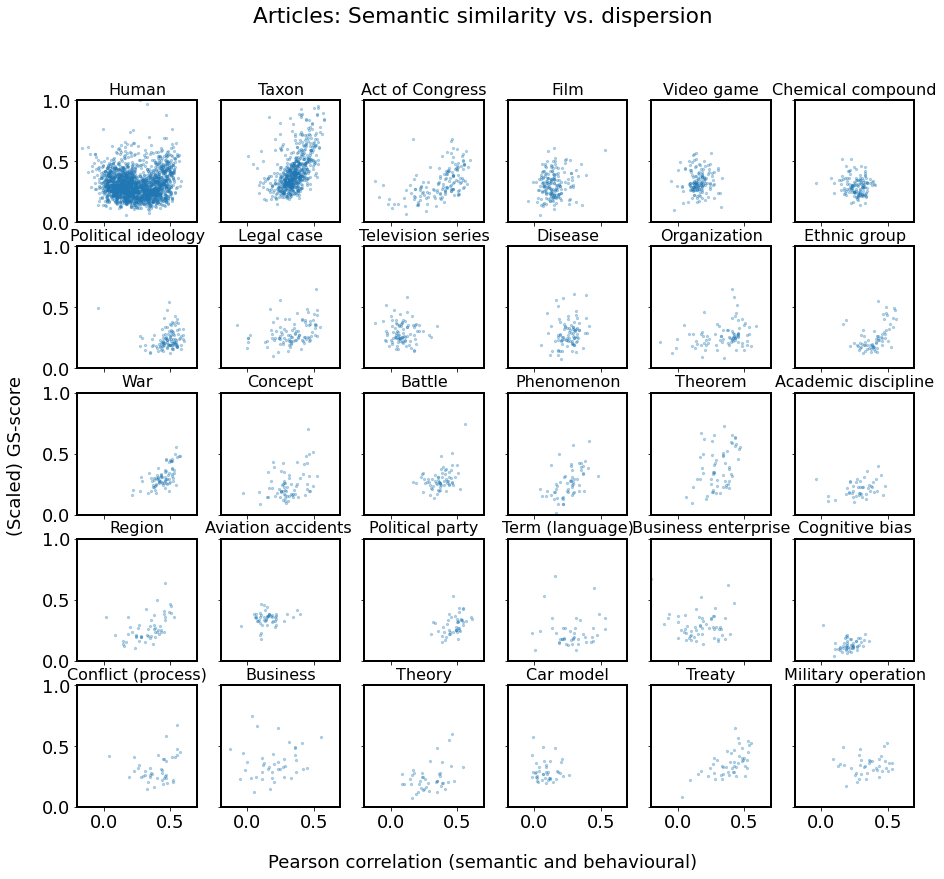

In [601]:
fig, axs = plt.subplots(5,6, figsize = (15,13), sharex = True, sharey=True)

for val,ax in zip(keys, axs.flatten()):
    temp = gs_pearson[gs_pearson["class"] == val]
    ax.scatter(temp["pearsonr"], temp["GS_score_scaled"],s = 5,alpha = 0.3)
#     ax.text(-0.2,0.9, "0.18 Correlation", fontsize = 18)
#     ax.set_xlabel("Pearson correlation")
#     ax.set_ylabel("(Scaled) GS-score")
    ax.set_xlim(-0.2,.7)
    ax.set_ylim(0,1)
    ax.set_title(val[0:19], fontsize = 16)


plt.suptitle("Articles: Semantic similarity vs. dispersion")

fig.text(0.5, 0.06, 'Pearson correlation (semantic and behavioural)', ha='center')
fig.text(0.06, 0.5, '(Scaled) GS-score', va='center', rotation='vertical')
plt.savefig("/scratch/venia/web2wiki/playground/semantic_sim_vs_dispersion_classes.jpg", dpi = 300, bbox_inches="tight")

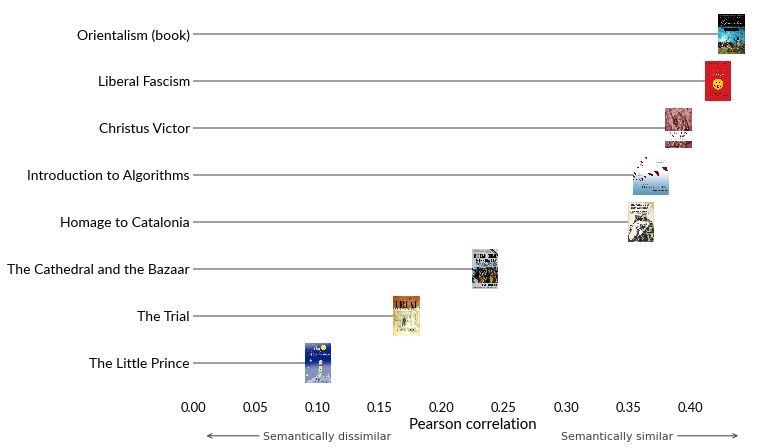

In [478]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = plt.subplots(figsize = (10,7))

data = wiki_metadata2[wiki_metadata2["class"] == "Book"].sort_values(by = "pearsonr",ascending = True)
vals = list(range(len(data)))
ax.scatter(x = data["pearsonr"],y = vals)
ax.set_xlim(0)
a,b = ax.get_ylim()
ax.set_ylim(a-0.4,b)



a,b = ax.get_xlim()
ax.set_xlim(0,b)

for i in range(len(vals)):
    z = (data["pearsonr"].values[i] - a) /  (b-a) 
    ax.axhline(vals[i], 0, z, color = "k",alpha = 0.5)
    
for x0, y0, path in zip(vals, data["pearsonr"], images):
    s1,s2,s3 = path.shape
    ab = AnnotationBbox(OffsetImage(path, zoom=40/s1), (y0, x0),(y0 , x0), frameon=False)
    ax.add_artist(ab)
ax.set_xlabel("Pearson correlation", fontsize = 15,fontname = "Lato")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticklabels([""] + list(data["page_title"].values) + [""], fontsize = 14, fontname = "Lato")
plt.tick_params(
    axis='both',         
    which='major',   
    bottom=True,   
    top=True, 
    size = 0,
    labelbottom=True) 
plt.xticks(fontsize=13,fontname = "Lato")

ymin, ymax = ax.get_ylim()
ydiff = ymax - ymin
xmin, xmax = ax.get_xlim()
xdiff = xmax - xmin

x_factortext = 0.24
x_factor = 0.02

y_factortext = 0.25
y_factor = 0.003

c = "#404040"

axis_args = {"va": "center", "ha": "center", "annotation_clip":False, "arrowprops":{"arrowstyle": "->", "color":c}, "color":c}

axis_labels = ["Semantically dissimilar","Semantically similar"]

ax.annotate(xytext=(xmin + x_factortext*xdiff, ymin-ydiff *.1), xy= (xmin + x_factor*xdiff, ymin-ydiff *.1), text =axis_labels[0],**axis_args, fontsize = 11)
ax.annotate(xytext=(xmax - x_factortext*xdiff, ymin-ydiff *.1), xy= (xmax - x_factor*xdiff, ymin-ydiff *.1), text =axis_labels[1], **axis_args, fontsize = 11)

# ax.annotate(xytext=(xmin-xdiff *.1, ymin + y_factortext*ydiff),rotation=90, xy= (xmin-xdiff *.1, ymin + y_factor*ydiff), text =axis_labels[2], **axis_args)
# ax.annotate(xytext=(xmin-xdiff *.1, ymax - y_factortext*ydiff),rotation=90, xy= (xmin-xdiff *.1,ymax - y_factor*ydiff), text =axis_labels[3], **axis_args)

plt.savefig("/scratch/venia/web2wiki/playground/books.jpg",dpi = 300, bbox_inches = "tight")

In [503]:
sim_beh["The Little Prince"].sort_values(ascending=False).head(10)

page_title
The Little Prince                       1.000000
The Hitchhiker's Guide to the Galaxy    0.988111
Garden-path sentence                    0.983971
Jonathan Livingston Seagull             0.982500
Stendhal syndrome                       0.980916
Onomatopoeia                            0.980475
Serial comma                            0.980116
Shorthand                               0.979823
Dewey Decimal Classification            0.979812
The Day of the Triffids                 0.979242
Name: The Little Prince, dtype: float64

In [505]:
sim_sem["The Little Prince"].sort_values(ascending=False).head(10)

page_title
The Little Prince                           1.000000
Baron Munchausen                            0.922941
The Dice Man                                0.916781
Perfume (novel)                             0.914671
Cinderella                                  0.913624
The Lord of the Rings                       0.912636
Moby-Dick                                   0.911001
Charles Bukowski                            0.910237
Oscar Wilde                                 0.908204
Harry Potter and the Philosopher's Stone    0.908202
Name: The Little Prince, dtype: float64

In [504]:
sim_beh["Introduction to Algorithms"].sort_values(ascending=False).head(10)

page_title
Introduction to Algorithms                           1.000000
The Art of Computer Programming                      0.989728
Computer science                                     0.980413
Trie                                                 0.980381
Dynamic programming                                  0.979228
Programming paradigm                                 0.976661
Compilers: Principles, Techniques, and Tools         0.974945
Structure and Interpretation of Computer Programs    0.973900
Time complexity                                      0.973257
Sorting algorithm                                    0.972095
Name: Introduction to Algorithms, dtype: float64

In [506]:
sim_sem["Introduction to Algorithms"].sort_values(ascending=False).head(10)

page_title
Introduction to Algorithms                           1.000000
Design Patterns                                      0.892347
Principia Mathematica                                0.885980
Pseudocode                                           0.882793
The C Programming Language                           0.879107
How to Lie with Statistics                           0.878074
Structure and Interpretation of Computer Programs    0.873936
Bible code                                           0.869743
Dewey Decimal Classification                         0.869399
Regular expression                                   0.864131
Name: Introduction to Algorithms, dtype: float64

In [643]:
wiki_metadata3 = wiki_metadata2[wiki_metadata2["count"]> 200]

In [644]:
wiki_metadata3[wiki_metadata3["class"] == "Term (language)"]

,wikibase_id,page_title,count,page_id,page_is_redirect,page_len,page_latest,class,quality,topic,topic1,subset_of,class_subset,pearsonr
122,Q748539,420 (cannabis culture),1261,145891,0.0,37500.0,1.035686e+09,Term (language),B,['Geography.Regions.Americas.North America'],Geography.Regions.Americas.North America,NaN,Term (language),-0.016483
2843,Q5072494,Channel drift,243,23575978,0.0,35067.0,1.029214e+09,Term (language),B,"['Culture.Media.Media*', 'Culture.Media.Televi...",Culture.Media.Media*,NaN,Term (language),-0.009277
21447,Q11695,DEFCON,282,287264,0.0,11550.0,1.035001e+09,Term (language),C,['History and Society.Military and warfare'],History and Society.Military and warfare,NaN,Term (language),0.001232
10783,Q3984457,Terminology of the British Isles,222,2318782,0.0,84390.0,1.036474e+09,Term (language),B,"['Geography.Regions.Europe.Europe*', 'Geograph...",Geography.Regions.Europe.Europe*,NaN,Term (language),0.159480
17694,Q103808,Loanword,245,59787,0.0,24224.0,1.035546e+09,Term (language),C,['Culture.Linguistics'],Culture.Linguistics,Word,Term (language),0.162436
23368,Q1200230,Price fixing,244,92026,0.0,29868.0,1.035521e+09,Term (language),C,"['History and Society.Business and economics',...",History and Society.Business and economics,NaN,Term (language),0.184797
11960,Q783092,Executive functions,213,3704475,0.0,92671.0,1.026529e+09,Term (language),B,"['STEM.Medicine & Health', 'STEM.STEM*']",STEM.Medicine & Health,NaN,Term (language),0.190360
16471,Q387294,Kayfabe,508,11145758,0.0,38209.0,1.031000e+09,Term (language),B,"['Culture.Media.Entertainment', 'Culture.Media...",Culture.Media.Entertainment,NaN,Term (language),0.209369
17903,Q39086874,Loot box,222,54877204,0.0,166689.0,1.035431e+09,Term (language),B,"['Culture.Internet culture', 'Culture.Media.Me...",Culture.Internet culture,NaN,Term (language),0.221540
18483,Q611145,Swaffelen,214,35857483,0.0,5791.0,1.018223e+09,Term (language),Start,['STEM.STEM*'],STEM.STEM*,NaN,Term (language),0.224410


In [645]:
wiki_metadata3[wiki_metadata3["class"] == "Term (language)"].head(4).append(wiki_metadata3[wiki_metadata3["class"] == "Term (language)"].tail(4))["page_title"].values

array(['420 (cannabis culture)', 'Channel drift', 'DEFCON',
       'Terminology of the British Isles', 'Balkanization',
       'Red states and blue states', 'Imperialism', 'Lebensraum'],
      dtype=object)

In [646]:
data 



,wikibase_id,page_title,count,page_id,page_is_redirect,page_len,page_latest,class,quality,topic,topic1,subset_of,class_subset,pearsonr,GS_score,GS_score_scaled,mean_p,pearsonr_scaled
73,Q748539,420 (cannabis culture),1261,145891,0.0,37500.0,1.035686e+09,Term (language),B,['Geography.Regions.Americas.North America'],Geography.Regions.Americas.North America,NaN,Term (language),-0.016483,0.647517,0.229235,0.280031,0.226323
105,Q11695,DEFCON,282,287264,0.0,11550.0,1.035001e+09,Term (language),C,['History and Society.Military and warfare'],History and Society.Military and warfare,NaN,Term (language),0.001232,0.589770,0.086303,0.280031,0.248187
264,Q102877,Castling,163,47642,0.0,26017.0,1.035770e+09,Term (language),C,['Culture.Sports'],Culture.Sports,Ply (game theory),Term (language),0.041773,0.654488,0.246489,0.280031,0.298224
415,Q362059,Jiffy (time),119,30169125,0.0,5499.0,1.029441e+09,Term (language),Start,"['STEM.Computing', 'STEM.STEM*']",STEM.Computing,NaN,Term (language),0.069441,0.768560,0.528833,0.280031,0.332371
4208,Q7260,Imperialism,231,15316,0.0,114968.0,1.036073e+09,Term (language),B,"['History and Society.Military and warfare', '...",History and Society.Military and warfare,Ideology,Term (language),0.469374,0.641432,0.214173,0.280031,0.825972
4297,Q1472463,Sick man of Europe,126,631338,0.0,17879.0,1.032240e+09,Term (language),B,['Geography.Regions.Europe.Europe*'],Geography.Regions.Europe.Europe*,NaN,Term (language),0.482988,0.711214,0.386894,0.280031,0.842774
4557,Q145560,Major non-NATO ally,171,3812445,0.0,25534.0,1.035452e+09,Term (language),GA,"['Geography.Regions.Asia.Asia*', 'History and ...",Geography.Regions.Asia.Asia*,Allies,Term (language),0.530695,0.697973,0.354120,0.280031,0.901655
4562,Q157136,Lebensraum,879,72297,0.0,89128.0,1.032533e+09,Term (language),B,"['Geography.Regions.Europe.Europe*', 'Geograph...",Geography.Regions.Europe.Europe*,NaN,Term (language),0.532542,0.659690,0.259363,0.280031,0.903935


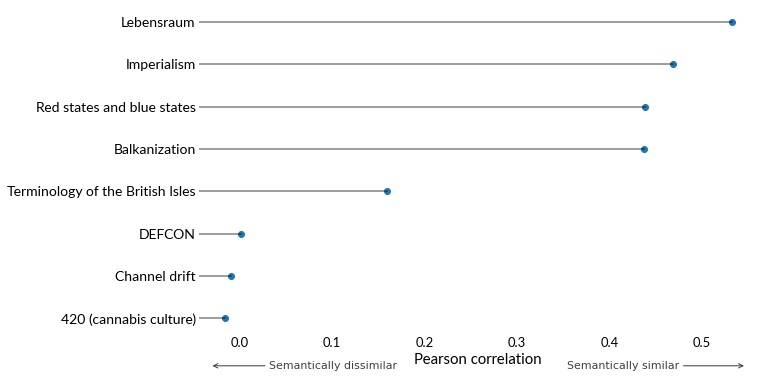

In [649]:

fig, ax = plt.subplots(figsize = (10,6))

data = wiki_metadata3[wiki_metadata3["class"] == "Term (language)"].sort_values(by = "pearsonr",ascending = True)
data = data.head(4).append(data.tail(4))
vals = list(range(len(data)))
ax.scatter(x = data["pearsonr"],y = vals)
# ax.set_xlim(0)
a,b = ax.get_ylim()
ax.set_ylim(a,b)

a,b = ax.get_xlim()
ax.set_xlim(a,b)

for i in range(len(vals)):
    z = (data["pearsonr"].values[i] - a) /  (b-a) 
    ax.axhline(vals[i], 0, z, color = "k",alpha = 0.5)
    
# for x0, y0, path in zip(vals, data["pearsonr"], images):
#     s1,s2,s3 = path.shape
#     ab = AnnotationBbox(OffsetImage(path, zoom=40/s1), (y0, x0),(y0 , x0), frameon=False)
#     ax.add_artist(ab)
ax.set_xlabel("Pearson correlation", fontsize = 15,fontname = "Lato")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_yticklabels([""] + list(data["page_title"].values) + [""], fontsize = 14, fontname = "Lato")
plt.tick_params(
    axis='both',         
    which='major',   
    bottom=True,   
    top=True, 
    size = 0,
    labelbottom=True) 
plt.xticks(fontsize=13,fontname = "Lato")

ymin, ymax = ax.get_ylim()
ydiff = ymax - ymin
xmin, xmax = ax.get_xlim()
xdiff = xmax - xmin

x_factortext = 0.24
x_factor = 0.02

y_factortext = 0.25
y_factor = 0.003

c = "#404040"

axis_args = {"va": "center", "ha": "center", "annotation_clip":False, "arrowprops":{"arrowstyle": "->", "color":c}, "color":c}

axis_labels = ["Semantically dissimilar","Semantically similar"]

ax.annotate(xytext=(xmin + x_factortext*xdiff, ymin-ydiff *.1), xy= (xmin + x_factor*xdiff, ymin-ydiff *.1), text =axis_labels[0],**axis_args, fontsize = 11)
ax.annotate(xytext=(xmax - x_factortext*xdiff, ymin-ydiff *.1), xy= (xmax - x_factor*xdiff, ymin-ydiff *.1), text =axis_labels[1], **axis_args, fontsize = 11)

# ax.annotate(xytext=(xmin-xdiff *.1, ymin + y_factortext*ydiff),rotation=90, xy= (xmin-xdiff *.1, ymin + y_factor*ydiff), text =axis_labels[2], **axis_args)
# ax.annotate(xytext=(xmin-xdiff *.1, ymax - y_factortext*ydiff),rotation=90, xy= (xmin-xdiff *.1,ymax - y_factor*ydiff), text =axis_labels[3], **axis_args)

plt.savefig("/scratch/venia/web2wiki/playground/terms2.jpg",dpi = 300, bbox_inches = "tight")

In [610]:
wiki_metadata3 = wiki_metadata2[wiki_metadata2["class"].isin(h_index.head(30).group)]
wiki_metadata3 = min_max_scaler(wiki_metadata3, "pearsonr")
wiki_metadata3 = wiki_metadata3.merge(gs_score)
wiki_metadata3["mean_p"] = wiki_metadata3.groupby("class")["pearsonr"].transform("mean")
wiki_metadata3 = wiki_metadata3.sort_values(by = "mean_p")

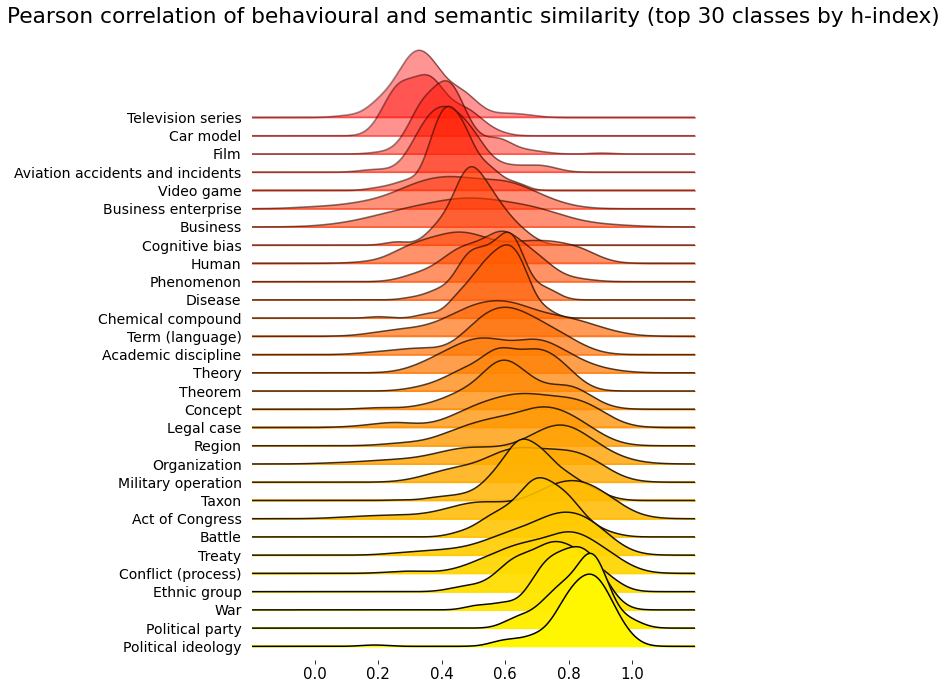

In [638]:
from matplotlib import cm
fig, ax = plt.subplots(figsize = (10,10))

# a = joyplot(wiki_metadata3,labels = wiki_metadata3["class"].drop_duplicates().values, by = 'mean_p', column = ['pearsonr_scaled',"GS_score_scaled"], colormap=cm.autumn, fade = True,range_style='all', title = "Pearson correlation of behavioural and semantic similarity (top 30 classes by h-index)", xlabelsize = 12, ylabelsize = 11, ax = ax, legend=True)
a = joyplot(wiki_metadata3,labels = wiki_metadata3["class"].drop_duplicates().values,  by = 'mean_p', column = ['pearsonr_scaled'], colormap=cm.autumn, fade = True,range_style='all', title = "Pearson correlation of behavioural and semantic similarity (top 30 classes by h-index)", xlabelsize = 15, ylabelsize = 14, ax = ax)


# ax.set_xlabel("Pearson correlation")
# a[-1].set_xtick
plt.savefig("/scratch/venia/web2wiki/playground/similarity2.jpg", dpi = 300, bbox_inches="tight")